# Task 3 - Cluster Analysis - Soft Clustering

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- customer types based on different features
- location based clustering

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

In [2]:
# import datasets
df_chicago = pd.read_csv("data/datasets/df_chicago.csv.zip")

## Functions defined for cluster analysis

### 1) Score functions

When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

A lower BIC score for a number of clusters indicates a more suitable and optimal choice of clusters, since it takes into account the complexity of the model and penalizes it for being overly complex (helpful to avoid overfitting).

The silhouette score is defined as measuring the mean distance of each data point to points within a cluster and the nearest neighbour cluster. For the silhouette score a higher value for a specific number of clusters, is a better choice.

Functions for those methods:

#### Silhouette score

In [3]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

#### Bayesian information criterion (BIC)

In [4]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

### 2) Scaling function

#### Data scaling function:

In [5]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df1)
    df_scaled = pd.DataFrame(df_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return df_scaled

### 3) Plotting functions:

#### Plot cluster information:

In [6]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

#### Plot clusters (scatterplot):

In [7]:
def plot_cluster_scatter(x_column, y_column, df, x_label, y_label):

    colors = {
        2: '#16C835', #green
        1: '#FF7C00',#orange
        4: '#8B2BE2',#violet
        5: '#843C0C',#brown
        0: '#023EFF',#blue
        6: '#FF1493',#rosa
        3:'#FF0000',#red
        7:'#808080'#grey
        # Add more colors for other clusters if needed
    }

    # Create the scatter plot
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    # Use hue parameter to color the data points based on the 'cluster' column
    sns.scatterplot(x=x_column, y=y_column,data=df,hue='cluster', palette=colors)

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

    # Move the legend outside and above the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
    # Show the plot
    plt.show()

#### Plot scatter with convex hulls:

In [8]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()

### 4) Functions for calculations:

#### Function for quantiles

In [9]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

### 5) Functions for mapping clusters on city map

In [94]:
def get_hex_ids_for_cluster_and_resolution(df, cluster_number, resolution):
    # Filter hex IDs for the specified cluster and resolution
    # Group hex IDs by cluster
    grouped_h3_hex_id = df.groupby('cluster')[resolution].apply(set).reset_index()
    
    # Get the list of hex IDs for clusters
    hex_ids_for_clusters = grouped_h3_hex_id[grouped_h3_hex_id['cluster'] == cluster_number][resolution].iloc[0]
    
    return hex_ids_for_clusters

In [95]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

<hr style="border: 1px solid #8888;">

## Preprocessing

### Preprocessing for clustering: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

To better interpret and analzye the clusters after processing, we convert the `Trip_Seconds` to `Trip_Minutes`. On the one hand we do this simply because minutes are easier to evaluate and on the other hand because the `Trip_Seconds` are always in 60 second-steps anyway.

In [10]:
df_chicago['Trip_Minutes'] = df_chicago['Trip_Seconds']/60
df_chicago.drop(['Trip_Seconds'], axis = 1,inplace =True)

In [11]:
df_chicago = df_chicago[(df_chicago['Trip_Miles'] < df_chicago['Trip_Miles'].quantile(0.95))]
df_chicago = df_chicago[(df_chicago['Trip_Minutes'] < df_chicago['Trip_Minutes'].quantile(0.95))]

In [12]:
# Drop unrealistic fast trips
df_chicago["velocity"] = (df_chicago["Trip_Miles"]/(df_chicago["Trip_Minutes"]/60)).round(2)
df_chicago = df_chicago[(df_chicago['velocity'] < df_chicago['velocity'].quantile(0.95))]
df_chicago = df_chicago[(df_chicago['velocity'] > df_chicago['velocity'].quantile(0.05))]
df_chicago = df_chicago.drop(['velocity'], axis = 1)

In [13]:
df_chicago.reset_index(inplace = True)

In [14]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Minutes',"Trip_Miles"]]
df_chicago_cluster

,start_time_hourly,Trip_Minutes,Trip_Miles
0,0,15.0,2.7
1,0,4.0,0.4
2,0,3.0,1.0
3,0,4.0,0.3
4,0,8.0,0.8
...,...,...,...
7247312,23,3.0,0.5
7247313,23,19.0,5.1
7247314,23,9.0,1.4
7247315,23,12.0,2.0


### Preprocessing for location based clustering: 

#### Creating `distance_to_city_center_pickup` and `distance_to_city_center_dropoff`

In [15]:
import dask.dataframe as dd
import math

# Coordinates of the city center of chicogo according to https://www.findlatitudeandlongitude.com/l/Chicago+City+centre/5712575/
chicago_city_center = (41.879519, -87.633026)

# Haversine function using Dask's map_partitions for distances in miles
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [16]:
ddfChicago = dd.from_pandas(pd.DataFrame(df_chicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_pickup'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Pickup_Centroid_Latitude'], df['Pickup_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
df_chicago = ddfChicago.compute()
df_chicago

,index,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,humidity,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,Trip_Minutes,distance_to_city_center_pickup
0,0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:00:00,2.7,NaN,NaN,28.0,8.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff,15.0,1.614272
1,1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff,4.0,3.617721
2,3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01 00:00:00,1.0,NaN,NaN,24.0,24.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff,3.0,2.685629
3,4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01 00:00:00,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff,4.0,0.495382
4,5,234917c65329ac7ed139a7d87e2f1d9238955ba3,bd95c3ff6f1c2e98b999c76ac1573ea273c1aacd2ccc0b...,2013-01-01 00:00:00,2013-01-01 00:00:00,0.8,NaN,NaN,22.0,22.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff,8.0,4.526819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247312,8974512,2f326845a0cd7cc6a8677587bb1ae32b95030e11,1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...,2013-12-31 23:00:00,2014-01-01 00:00:00,0.5,1.703128e+10,1.703128e+10,28.0,28.0,...,89.0,-11.00,217.0,1.0,mist,882664c1adfffff,872664c1affffff,862664c1fffffff,3.0,0.495382
7247313,8974514,6f0446f9dbc91bcd20e29e5b4b415c40310b0818,bfb5c2ad40103c9891e7ee4713e93ccd75e741099b7498...,2013-12-31 23:00:00,2014-01-01 00:00:00,5.1,1.703106e+10,1.703116e+10,6.0,16.0,...,89.0,-11.00,217.0,1.0,mist,882664c10dfffff,872664c10ffffff,862664c17ffffff,19.0,4.435183
7247314,8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,2013-12-31 23:00:00,2014-01-01 00:00:00,1.4,1.703108e+10,1.703184e+10,8.0,8.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,9.0,0.893287
7247315,8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,2013-12-31 23:00:00,2014-01-01 00:00:00,2.0,1.703132e+10,1.703133e+10,32.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e3fffff,872664c1effffff,862664c1fffffff,12.0,0.725199


In [17]:
ddfChicago = dd.from_pandas(pd.DataFrame(df_chicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_dropoff'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Dropoff_Centroid_Latitude'], df['Dropoff_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
df_chicago = ddfChicago.compute()
df_chicago

,index,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,Trip_Minutes,distance_to_city_center_pickup,distance_to_city_center_dropoff
0,0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:00:00,2.7,NaN,NaN,28.0,8.0,...,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff,15.0,1.614272,1.387700
1,1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff,4.0,3.617721,3.548918
2,3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01 00:00:00,1.0,NaN,NaN,24.0,24.0,...,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff,3.0,2.685629,2.685629
3,4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01 00:00:00,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff,4.0,0.495382,0.587129
4,5,234917c65329ac7ed139a7d87e2f1d9238955ba3,bd95c3ff6f1c2e98b999c76ac1573ea273c1aacd2ccc0b...,2013-01-01 00:00:00,2013-01-01 00:00:00,0.8,NaN,NaN,22.0,22.0,...,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff,8.0,4.526819,4.526819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247312,8974512,2f326845a0cd7cc6a8677587bb1ae32b95030e11,1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...,2013-12-31 23:00:00,2014-01-01 00:00:00,0.5,1.703128e+10,1.703128e+10,28.0,28.0,...,-11.00,217.0,1.0,mist,882664c1adfffff,872664c1affffff,862664c1fffffff,3.0,0.495382,0.495382
7247313,8974514,6f0446f9dbc91bcd20e29e5b4b415c40310b0818,bfb5c2ad40103c9891e7ee4713e93ccd75e741099b7498...,2013-12-31 23:00:00,2014-01-01 00:00:00,5.1,1.703106e+10,1.703116e+10,6.0,16.0,...,-11.00,217.0,1.0,mist,882664c10dfffff,872664c10ffffff,862664c17ffffff,19.0,4.435183,7.088074
7247314,8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,2013-12-31 23:00:00,2014-01-01 00:00:00,1.4,1.703108e+10,1.703184e+10,8.0,8.0,...,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,9.0,0.893287,1.959038
7247315,8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,2013-12-31 23:00:00,2014-01-01 00:00:00,2.0,1.703132e+10,1.703133e+10,32.0,33.0,...,-11.00,217.0,1.0,mist,882664c1e3fffff,872664c1effffff,862664c1fffffff,12.0,0.725199,1.609951


<hr style="border: 1px solid #8888;">

## 3.1 First Cluster Analysis: `start_time_hourly`

In [18]:
df_cluster_start = df_chicago_cluster[['start_time_hourly']]

#### Scaling the data:

In [19]:
df_start_scaled = scaling_data(df_cluster_start)

### 3.1.1 Validation of Number of Clusters

In [55]:
df_score = df_start_scaled.sample(350000, random_state=42)
df_score

,start_time_hourly
7859463,-1.983130
1567295,-1.983130
1532308,-0.670610
8608880,1.225252
1538808,0.350239
...,...
3671881,1.225252
4277237,0.787746
5670711,-0.233104
8230356,1.225252


### Silhouette score

In [15]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

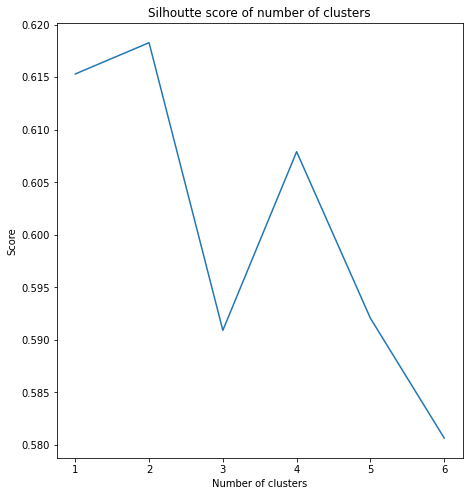

In [16]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_starttime')
plt.show()

### Bayesian information criterion (BIC)

In [17]:
clusters_bic, scores_bic = bic(df_score, 6)

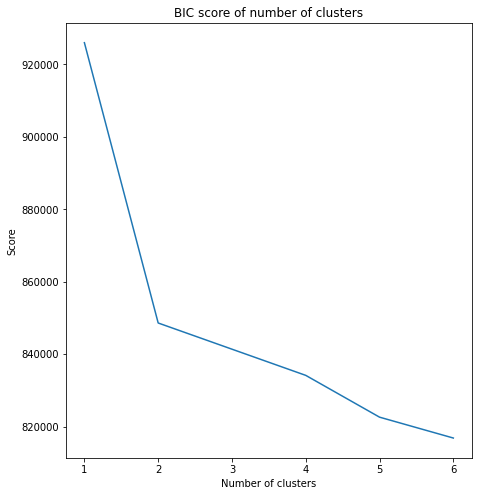

In [18]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_starttime')
plt.show()

We decide to choose 4 clusters, since we have a peak in the silhouette score and the BIC score decreases from a number of 2, so is relatively low at 4.

### 3.1.2 Computing Clusters with Gaussian Mixture Model

In [20]:
gm = GaussianMixture(n_components=4, random_state=42, n_init = 15).fit(df_start_scaled)

In [21]:
cluster = gm.predict(df_start_scaled)

In [22]:
cluster_prob = gm.predict_proba(df_start_scaled)

In [23]:
df_cluster_start["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/1123111176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_start["cluster"] = cluster


In [24]:
for k in range(4):
    df_cluster_start[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [25]:
df_cluster_start

,start_time_hourly,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob
0,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
1,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
2,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
3,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
4,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
...,...,...,...,...,...,...
7247312,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01
7247313,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01
7247314,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01
7247315,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01


### 3.1.3 Analyzing & Labeling clusters

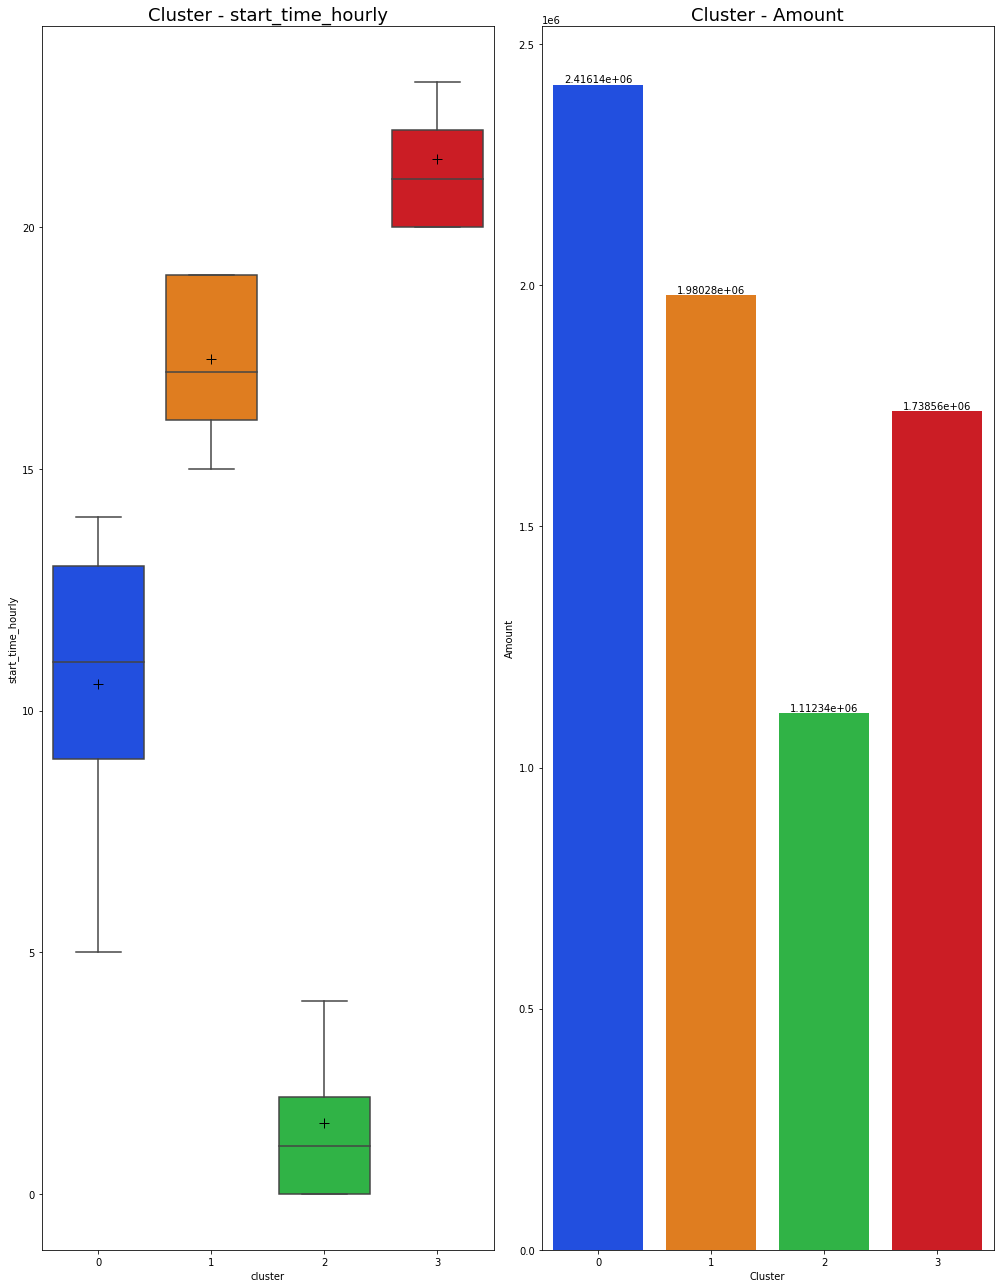

In [26]:
plot_information_about_clusters(df_cluster_start, ['start_time_hourly'], 'cluster')

In [28]:
dfChicago_clu_start_time_quantiles = get_quantiles_of_clusters(df_cluster_start, 4, 'cluster')
dfChicago_clu_start_time_quantiles

,start_time_hourly,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,,
0,9.0 - 13.0,0.92 - 1.0,0.0 - 0.08,0.0 - 0.0,0.0 - 0.0,2416138.0,33.34
1,16.0 - 19.0,0.01 - 0.19,0.74 - 0.92,0.0 - 0.0,0.0 - 0.24,1980282.0,27.32
2,0.0 - 2.0,0.0 - 0.01,0.0 - 0.0,0.99 - 1.0,0.0 - 0.0,1112340.0,15.35
3,20.0 - 22.0,0.0 - 0.0,0.06 - 0.38,0.0 - 0.0,0.61 - 0.94,1738557.0,23.99


In [29]:
label_names = {'0': "Morning (before work) Commuters", 
               '1': "Evening (after work) Commuters",
               '2': "Night Riders - Party People",
              '3': "Evening Customers"}

# integrating our labeled clusters in the dataframe
df_cluster_start['Cluster_Label'] = df_cluster_start['cluster'].astype(str)
df_cluster_start = df_cluster_start.replace({"Cluster_Label": label_names})

In [30]:
dfChicago_clu_start_time_index = df_cluster_start
dfChicago_clu_start_time_index['Trip_Index'] = df_cluster_start.index
dfChicago_clu_start_time_index

,start_time_hourly,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,Cluster_Label,Trip_Index
0,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57,Night Riders - Party People,0
1,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57,Night Riders - Party People,1
2,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57,Night Riders - Party People,2
3,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57,Night Riders - Party People,3
4,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57,Night Riders - Party People,4
...,...,...,...,...,...,...,...,...
7247312,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01,Evening Customers,7247312
7247313,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01,Evening Customers,7247313
7247314,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01,Evening Customers,7247314
7247315,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01,Evening Customers,7247315


### 3.1.4 Plotting the Clustering Results

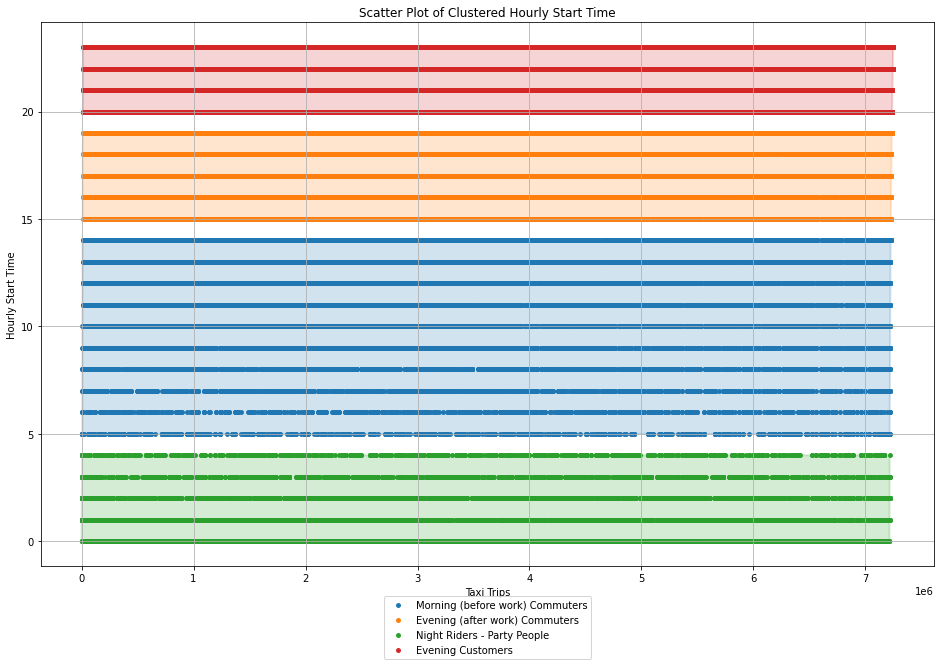

In [31]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_start_time_index.sample(n=100000), x_col='Trip_Index', y_col='start_time_hourly', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Hourly Start Time", plot_title='Scatter Plot of Clustered Hourly Start Time', leg_loc='lower center', anchor=(0.5, -0.18))

<hr style="border: 1px solid #8888;">

## 3.2 Second Cluster Analysis: `Trip_Miles`

#### Scaling the data:

In [32]:
df_cluster_miles = df_chicago_cluster[['Trip_Miles']]

In [33]:
df_miles_scaled = scaling_data(df_cluster_miles)

### 2.1 Decision for number of clusters

In [73]:
df_score = df_miles_scaled.sample(350000, random_state=42)
df_score

,Trip_Miles
7859463,-1.123370
1567295,-1.046943
1532308,-0.511955
8608880,-1.215082
1538808,-0.817662
...,...
3671881,0.099460
4277237,1.093009
5670711,-0.817662
8230356,-0.917017


### Silhouette score

In [29]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

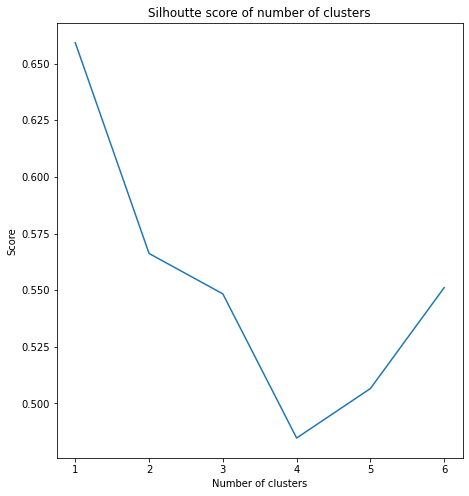

In [30]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_miles')
plt.show()

### Bayesian information criterion (BIC)

In [31]:
clusters_bic, scores_bic = bic(df_score, 6)

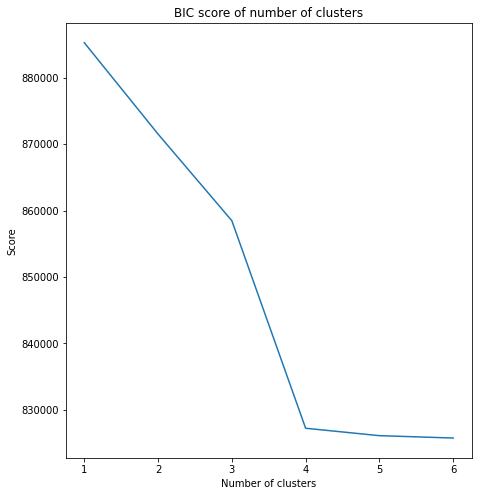

In [32]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_miles')
plt.show()

Here we decide for 3 as the number of clusters to work with, because there the BIC score has a drop and the silhouette score is is still quite high there. Since it is not an appropriate choice to slect too many clusters, we decided against using five or more here.

### 2.2 Use Gaussian Mixture Model and discover cluster

In [34]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_miles_scaled)

In [35]:
cluster = gm.predict(df_miles_scaled)

In [36]:
cluster_prob = gm.predict_proba(df_miles_scaled)

In [37]:
df_cluster_miles["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/2624358545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_miles["cluster"] = cluster


In [38]:
for k in range(3):
    df_cluster_miles[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [39]:
df_cluster_miles

,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob
0,2.7,2,2.467813e-04,0.265397,0.734356
1,0.4,0,9.577545e-01,0.003228,0.039017
2,1.0,0,8.300077e-01,0.008476,0.161516
3,0.3,0,9.636555e-01,0.003140,0.033205
4,0.8,0,9.010509e-01,0.005352,0.093597
...,...,...,...,...,...
7247312,0.5,0,9.495735e-01,0.003457,0.046970
7247313,5.1,1,4.687840e-20,0.999945,0.000055
7247314,1.4,0,5.023625e-01,0.025430,0.472207
7247315,2.0,2,3.966150e-02,0.080708,0.879630


### 2.3 Analyze & Label the cluster

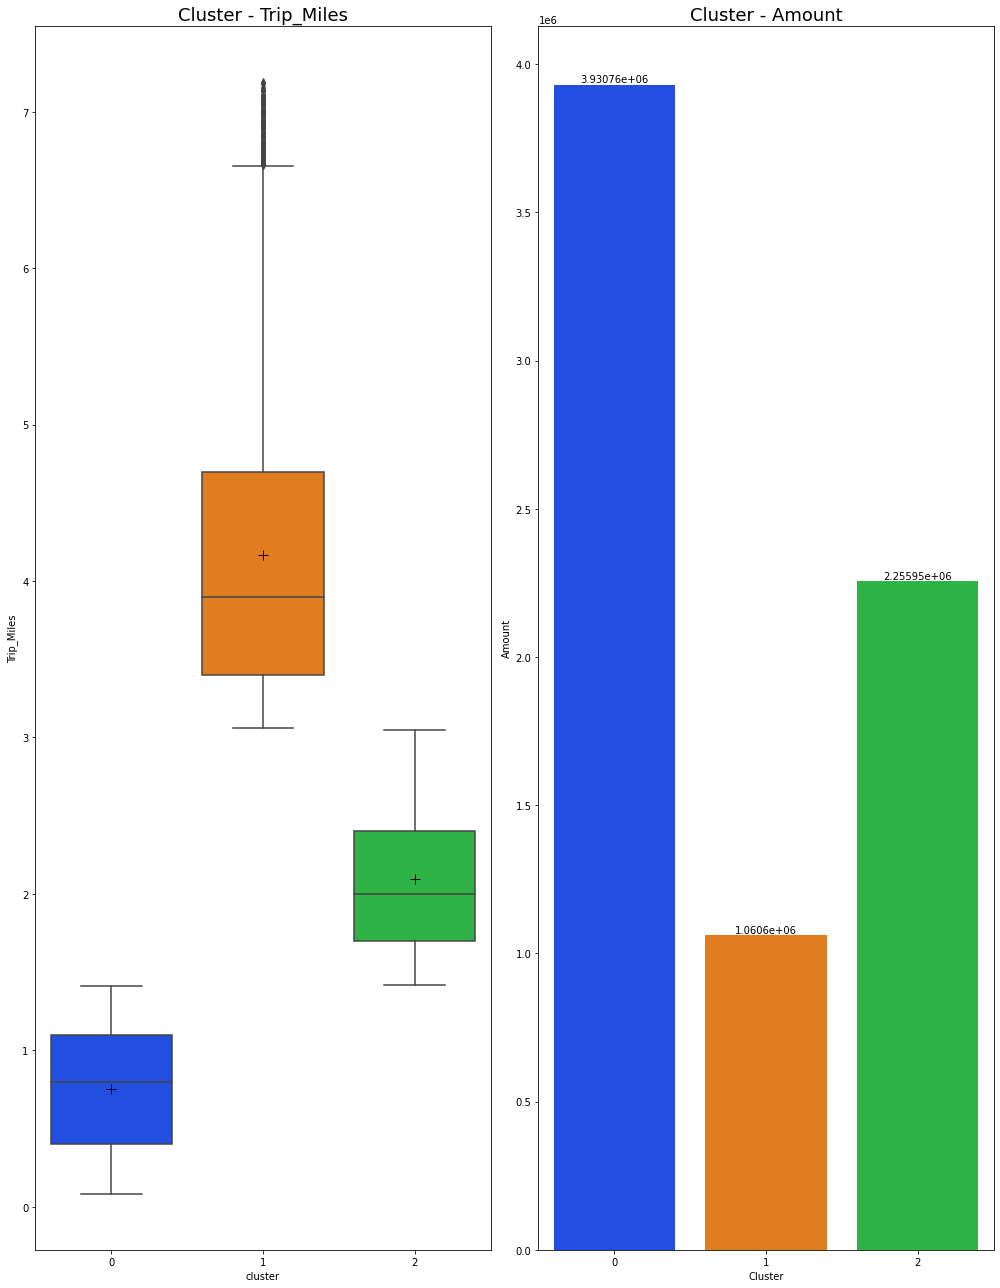

In [40]:
plot_information_about_clusters(df_cluster_miles, ['Trip_Miles'], 'cluster')

In [41]:
dfChicago_clu_miles_time_quantiles = get_quantiles_of_clusters(df_cluster_miles, 3, 'cluster')
dfChicago_clu_miles_time_quantiles

,Trip_Miles,cluster_0_prob,cluster_1_prob,cluster_2_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,
0,0.4 - 1.1,0.77 - 0.96,0.0 - 0.01,0.04 - 0.21,3930764.0,54.24
1,3.4 - 4.7,0.0 - 0.0,0.76 - 1.0,0.0 - 0.24,1060600.0,14.63
2,1.7 - 2.4,0.0 - 0.19,0.05 - 0.15,0.68 - 0.86,2255953.0,31.13


In [42]:
label_names = {'0': "Short Trips", 
               '1': "Long Trips",
               '2': "Medium Trips"}

# integrating our labeled clusters in the dataframe
df_cluster_miles['Cluster_Label'] = df_cluster_miles['cluster'].astype(str)
df_cluster_miles = df_cluster_miles.replace({"Cluster_Label": label_names})

In [43]:
dfChicago_clu_miles_index = df_cluster_miles
dfChicago_clu_miles_index['Trip_Index'] = df_cluster_miles.index
dfChicago_clu_miles_index

,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,Cluster_Label,Trip_Index
0,2.7,2,2.467813e-04,0.265397,0.734356,Medium Trips,0
1,0.4,0,9.577545e-01,0.003228,0.039017,Short Trips,1
2,1.0,0,8.300077e-01,0.008476,0.161516,Short Trips,2
3,0.3,0,9.636555e-01,0.003140,0.033205,Short Trips,3
4,0.8,0,9.010509e-01,0.005352,0.093597,Short Trips,4
...,...,...,...,...,...,...,...
7247312,0.5,0,9.495735e-01,0.003457,0.046970,Short Trips,7247312
7247313,5.1,1,4.687840e-20,0.999945,0.000055,Long Trips,7247313
7247314,1.4,0,5.023625e-01,0.025430,0.472207,Short Trips,7247314
7247315,2.0,2,3.966150e-02,0.080708,0.879630,Medium Trips,7247315


### 2.4 Plotting the Clustering Results

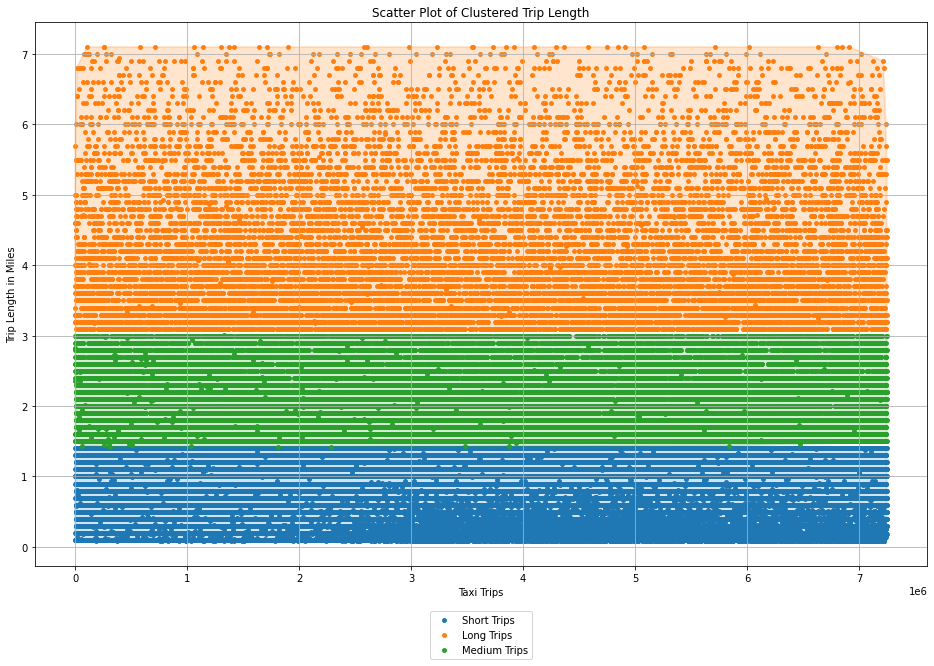

In [44]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_miles_index.sample(n=100000), x_col='Trip_Index', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Length in Miles", plot_title='Scatter Plot of Clustered Trip Length', leg_loc='lower center', anchor=(0.5, -0.18))

<hr style="border: 1px solid #8888;">

## 3. Third Cluster Analysis: `Trip_Minutes`

#### Scaling the data:

In [45]:
df_cluster_minutes = df_chicago_cluster[['Trip_Minutes']]

In [46]:
df_minutes_scaled = scaling_data(df_cluster_minutes)

### 3.1 Decision for number of clusters

In [35]:
df_score = df_minutes_scaled.sample(350000, random_state=42)
df_score

,Trip_Minutes
7859463,0.403036
1567295,0.873073
1532308,-0.537038
8608880,-1.477111
1538808,-1.242093
...,...
3671881,0.403036
4277237,-0.302019
5670711,-1.007074
8230356,0.403036


### Silhouette score

In [36]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

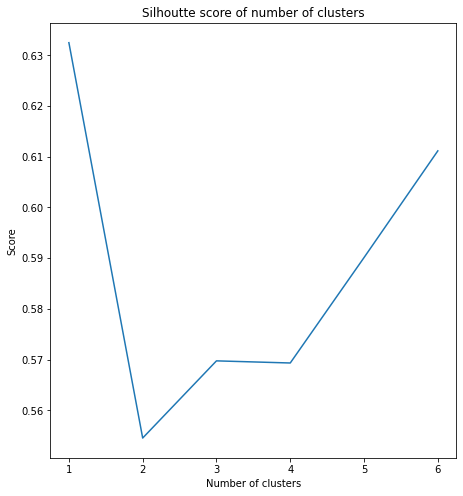

In [37]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_minutes')
plt.show()

### Bayesian information criterion (BIC)

In [38]:
clusters_bic, scores_bic = bic(df_score, 6)

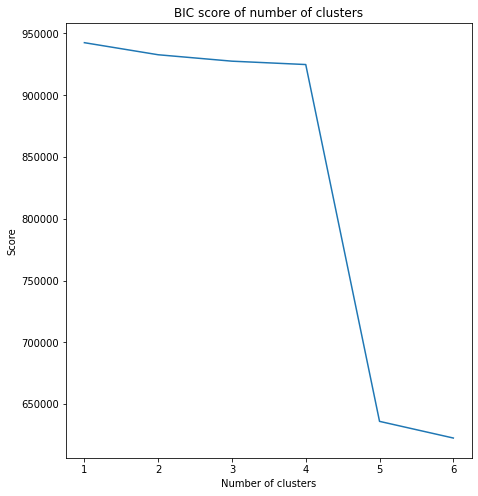

In [39]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_minutes')
plt.show()

For this clustering we choose a number of five clusters. Because looking especially on the BIC score less clusters are not appropriate and for 5 clusters the silhouette score also increases.

### 3.2 Use Gaussian Mixture Model and discover cluster

In [47]:
gm = GaussianMixture(n_components=5, random_state=42, n_init = 15).fit(df_minutes_scaled)

In [48]:
cluster = gm.predict(df_minutes_scaled)

In [49]:
cluster_prob = gm.predict_proba(df_minutes_scaled)

In [50]:
df_cluster_minutes["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/333786254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_minutes["cluster"] = cluster


In [51]:
for k in range(5):
    df_cluster_minutes[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [52]:
df_cluster_minutes

,Trip_Minutes,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob
0,15.0,1,1.405756e-13,9.341037e-01,0.027459,3.843684e-02,2.862332e-87
1,4.0,4,2.769192e-01,1.012760e-10,0.008584,7.183772e-26,7.144964e-01
2,3.0,4,7.314536e-02,1.707580e-12,0.002420,3.100481e-29,9.244350e-01
3,4.0,4,2.769192e-01,1.012760e-10,0.008584,7.183772e-26,7.144964e-01
4,8.0,2,3.014629e-01,1.596802e-04,0.698377,7.139574e-14,1.130001e-13
...,...,...,...,...,...,...,...
7247312,3.0,4,7.314536e-02,1.707580e-12,0.002420,3.100481e-29,9.244350e-01
7247313,19.0,3,1.043470e-27,1.197706e-02,0.000008,9.880146e-01,1.405753e-158
7247314,9.0,2,4.462110e-02,1.815642e-03,0.953563,1.649837e-11,3.122675e-20
7247315,12.0,2,2.595991e-06,3.227218e-01,0.677264,1.123667e-05,1.062027e-47


### 3.3 Analyze & Label the cluster

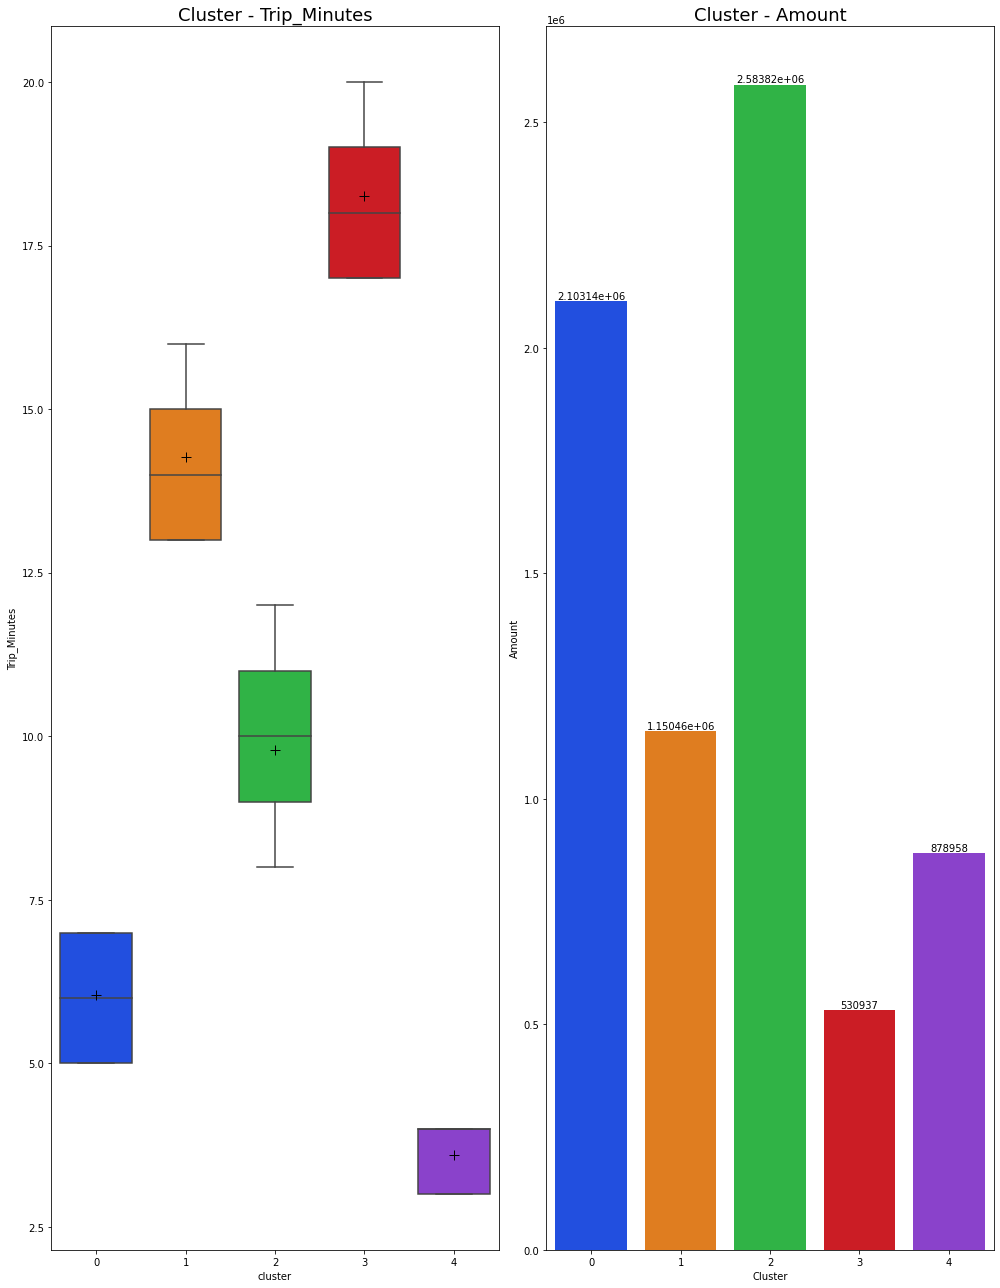

In [53]:
plot_information_about_clusters(df_cluster_minutes, ['Trip_Minutes'], 'cluster')

In [54]:
dfChicago_clu_minutes_quantiles = get_quantiles_of_clusters(df_cluster_minutes, 5, 'cluster')
dfChicago_clu_minutes_quantiles

,Trip_Minutes,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,,,
0,5.0 - 7.0,0.72 - 0.91,0.0 - 0.0,0.04 - 0.28,0.0 - 0.0,0.0 - 0.05,2103142.0,29.02
1,13.0 - 15.0,0.0 - 0.0,0.69 - 0.9,0.03 - 0.31,0.0 - 0.04,0.0 - 0.0,1150461.0,15.87
2,9.0 - 11.0,0.0 - 0.04,0.0 - 0.08,0.7 - 0.95,0.0 - 0.0,0.0 - 0.0,2583819.0,35.65
3,17.0 - 19.0,0.0 - 0.0,0.01 - 0.29,0.0 - 0.0,0.7 - 0.99,0.0 - 0.0,530937.0,7.33
4,3.0 - 4.0,0.07 - 0.28,0.0 - 0.0,0.0 - 0.01,0.0 - 0.0,0.71 - 0.92,878958.0,12.13


In [97]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Medium Trips",
              '3': "Long Trips",
               '4': "Short Trips"}

# integrating our labeled clusters in the dataframe
df_cluster_minutes['Cluster_Label'] = df_cluster_minutes['cluster'].astype(str)
df_cluster_minutes = df_cluster_minutes.replace({"Cluster_Label": label_names})

In [98]:
dfChicago_clu_minutes_index = df_cluster_minutes
dfChicago_clu_minutes_index['Trip_Index'] = df_cluster_minutes.index
dfChicago_clu_minutes_index

,Trip_Minutes,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,Cluster_Label,Trip_Index
0,15.0,1,1.405756e-13,9.341037e-01,0.027459,3.843684e-02,2.862332e-87,Night Riders - Party People,0
1,4.0,4,2.769192e-01,1.012760e-10,0.008584,7.183772e-26,7.144964e-01,Morning Commuters,1
3,3.0,4,7.314536e-02,1.707580e-12,0.002420,3.100481e-29,9.244350e-01,Morning Commuters,3
4,4.0,4,2.769192e-01,1.012760e-10,0.008584,7.183772e-26,7.144964e-01,Morning Commuters,4
5,8.0,2,3.014629e-01,1.596802e-04,0.698377,7.139574e-14,1.130001e-13,Morning Commuters,5
...,...,...,...,...,...,...,...,...,...
8974512,3.0,4,7.314536e-02,1.707580e-12,0.002420,3.100481e-29,9.244350e-01,Morning Commuters,8974512
8974514,19.0,3,1.043470e-27,1.197706e-02,0.000008,9.880146e-01,1.405753e-158,Night Riders - Party People,8974514
8974515,9.0,2,4.462110e-02,1.815642e-03,0.953563,1.649837e-11,3.122675e-20,Morning Commuters,8974515
8974517,12.0,2,2.595991e-06,3.227218e-01,0.677264,1.123667e-05,1.062027e-47,Morning Commuters,8974517


### 3.4 Plotting the Clustering Results

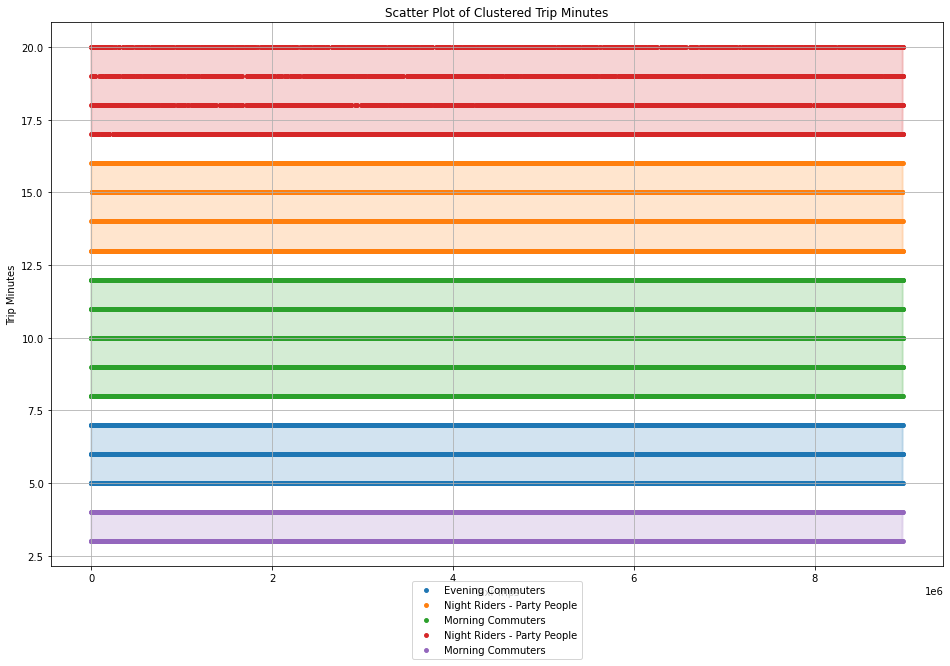

In [99]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_minutes_index.sample(n=100000), x_col='Trip_Index', y_col='Trip_Minutes', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Minutes", plot_title='Scatter Plot of Clustered Trip Minutes', leg_loc='lower center', anchor=(0.5, -0.18))

<hr style="border: 1px solid #8888;">

## 4. Fourth Cluster Analysis: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

#### Scaling the data:

In [55]:
df_cluster_scaled = scaling_data(df_chicago_cluster)

In [56]:
df_cluster_scaled

,start_time_hourly,Trip_Minutes,Trip_Miles
0,-1.983130,1.343110,0.787302
1,-1.983130,-1.242093,-0.970516
2,-1.983130,-1.477111,-0.511955
3,-1.983130,-1.242093,-1.046943
4,-1.983130,-0.302019,-0.664808
...,...,...,...
7247312,1.371088,-1.477111,-0.894089
7247313,1.371088,2.283184,2.621546
7247314,1.371088,-0.067001,-0.206247
7247315,1.371088,0.638055,0.252314


### 4.1 Decision for number of clusters

In [27]:
df_score = df_cluster_scaled.sample(750000, random_state=42)
df_score

,start_time_hourly,Trip_Miles,Trip_Minutes
7859463,-1.983130,-1.123370,0.403036
1567295,-1.983130,-1.046943,0.873073
1532308,-0.670610,-0.511955,-0.537038
8608880,1.225252,-1.215082,-1.477111
1538808,0.350239,-0.817662,-1.242093
...,...,...,...
5094111,-0.670610,-0.129820,-0.772056
1702540,0.496074,-0.741235,-1.477111
7783643,-1.545624,-0.664808,-1.242093
4667153,0.350239,-1.123370,-0.067001


### Silhouette score

In [28]:
#clusters_sil, scores_sil = silhoutte(df_score, 10)

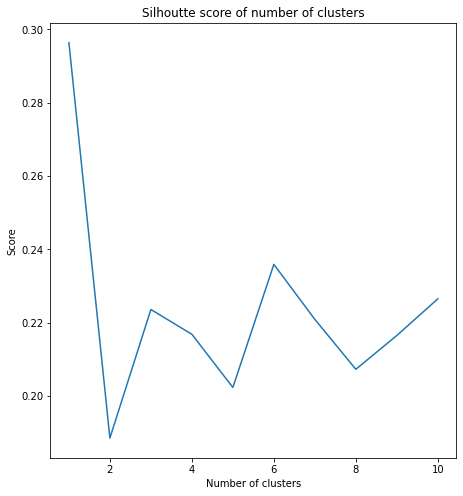

In [61]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score')
plt.show()

### Bayesian information criterion (BIC)

In [31]:
#clusters_bic, scores_bic = bic(df_score, 10)

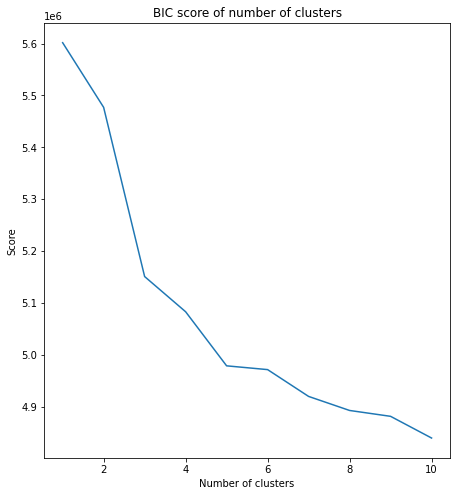

In [59]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score')
plt.show()

### 4.2 Use Gaussian Mixture Model and discover cluster

In [58]:
gm = GaussianMixture(n_components=6, random_state=42, n_init = 15).fit(df_cluster_scaled)

In [59]:
cluster = gm.predict(df_cluster_scaled)

In [60]:
cluster_prob = gm.predict_proba(df_cluster_scaled)

In [61]:
df_chicago_cluster["cluster"] = cluster

In [62]:
for k in range(6):
    df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [63]:
df_chicago_cluster

,start_time_hourly,Trip_Minutes,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob
0,0,15.0,2.7,5,9.241915e-05,3.058123e-19,1.994549e-01,5.906753e-31,3.893079e-257,0.800453
1,0,4.0,0.4,2,1.320698e-02,2.272388e-24,9.855189e-01,4.903452e-29,2.044949e-05,0.001254
2,0,3.0,1.0,2,8.551338e-02,1.063691e-25,9.128693e-01,5.616273e-32,2.112221e-40,0.001617
3,0,4.0,0.3,2,7.928040e-03,3.362586e-24,9.853811e-01,7.761108e-29,5.365695e-03,0.001325
4,0,8.0,0.8,2,7.312054e-03,2.091962e-21,9.536179e-01,5.872735e-28,8.126666e-18,0.039070
...,...,...,...,...,...,...,...,...,...,...
7247312,23,3.0,0.5,3,5.465788e-02,8.863715e-03,7.358218e-96,9.348431e-01,1.817717e-10,0.001635
7247313,23,19.0,5.1,1,9.925098e-18,9.669726e-01,8.885553e-100,6.378516e-10,0.000000e+00,0.033027
7247314,23,9.0,1.4,0,4.581682e-01,2.344592e-01,4.574040e-99,2.592919e-01,2.035371e-68,0.048081
7247315,23,12.0,2.0,1,1.090692e-01,7.237247e-01,1.035550e-100,1.630681e-02,6.001451e-141,0.150899


### 4.3 Analyze & Label the cluster

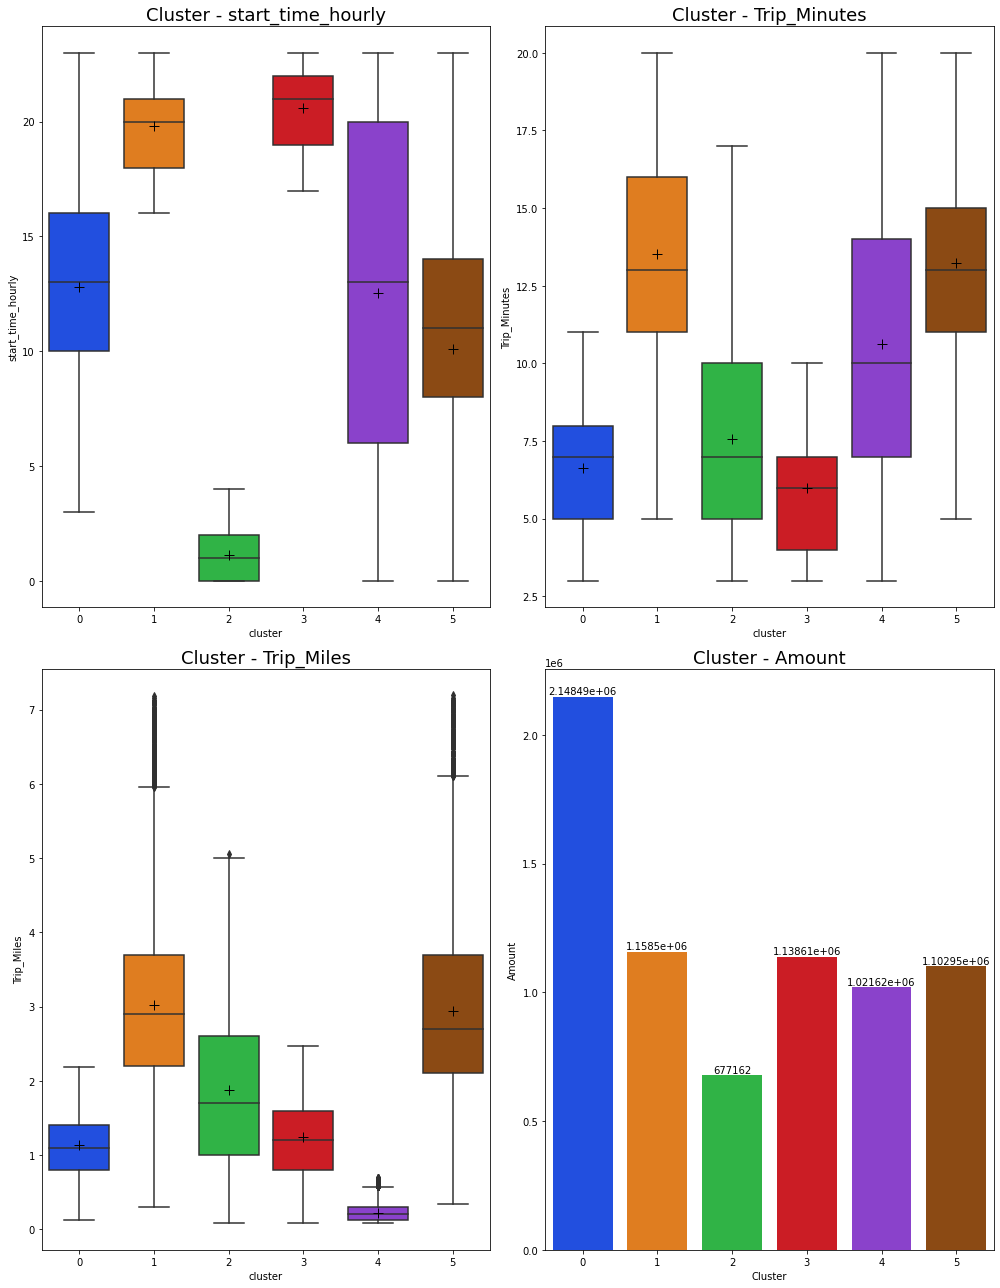

In [64]:
plot_information_about_clusters(df_chicago_cluster, ['start_time_hourly', 'Trip_Minutes', 'Trip_Miles'], 'cluster')

In [66]:
dfChicago_clu_combined_quantiles = get_quantiles_of_clusters(df_chicago_cluster, 6, 'cluster')
dfChicago_clu_combined_quantiles

,start_time_hourly,Trip_Minutes,Trip_Miles,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,,,,,,
0,10.0 - 16.0,5.0 - 8.0,0.8 - 1.4,0.76 - 0.98,0.0 - 0.01,0.0 - 0.0,0.0 - 0.02,0.0 - 0.0,0.01 - 0.08,2148489.0,29.65
1,18.0 - 21.0,11.0 - 16.0,2.2 - 3.7,0.0 - 0.01,0.68 - 0.93,0.0 - 0.0,0.0 - 0.02,0.0 - 0.0,0.06 - 0.19,1158496.0,15.99
2,0.0 - 2.0,5.0 - 10.0,1.0 - 2.6,0.0 - 0.06,0.0 - 0.0,0.85 - 0.96,0.0 - 0.0,0.0 - 0.0,0.0 - 0.07,677162.0,9.34
3,19.0 - 22.0,4.0 - 7.0,0.8 - 1.6,0.04 - 0.21,0.01 - 0.07,0.0 - 0.0,0.65 - 0.91,0.0 - 0.0,0.0 - 0.01,1138606.0,15.71
4,6.0 - 20.0,7.0 - 14.0,0.12 - 0.3,0.0 - 0.0,0.0 - 0.02,0.0 - 0.0,0.0 - 0.0,0.92 - 0.98,0.01 - 0.03,1021616.0,14.10
5,8.0 - 14.0,11.0 - 15.0,2.1 - 3.7,0.0 - 0.06,0.0 - 0.02,0.0 - 0.0,0.0 - 0.0,0.0 - 0.0,0.73 - 1.0,1102948.0,15.22


In [68]:
label_names = {'0': "Short Distance - Short Duration Trips", 
               '1': "Evening Customers - Long Trips",
               '2': "Night Riders - Party People",
               '3': "Evening Customers - Short Trips", 
               '4': "Short Distance - Long Duration Trips",
               '5': "Morning (before work) Commuters",
               }

# integrating our labeled clusters in the dataframe
df_chicago_cluster['Cluster_Label'] = df_chicago_cluster['cluster'].astype(str)
df_chicago_cluster = df_chicago_cluster.replace({"Cluster_Label": label_names})

In [ ]:
dfChicago_clu_minutes_index = df_cluster_minutes
dfChicago_clu_minutes_index['Trip_Index'] = df_cluster_minutes.index
dfChicago_clu_minutes_index

### 4.4 Plotting the Clustering Results

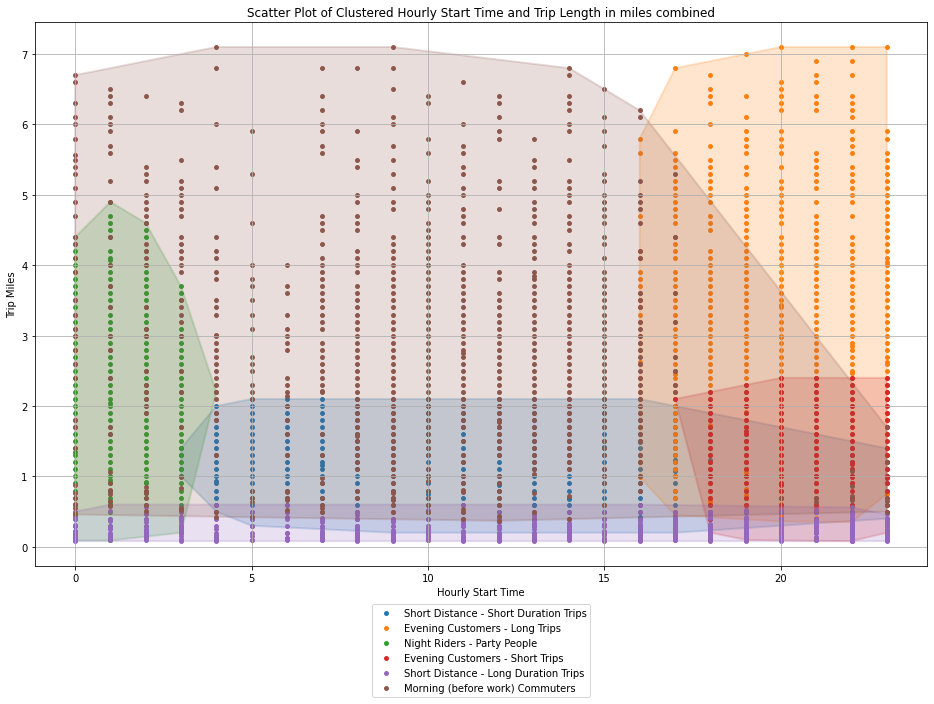

In [69]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_cluster.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Length in miles combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

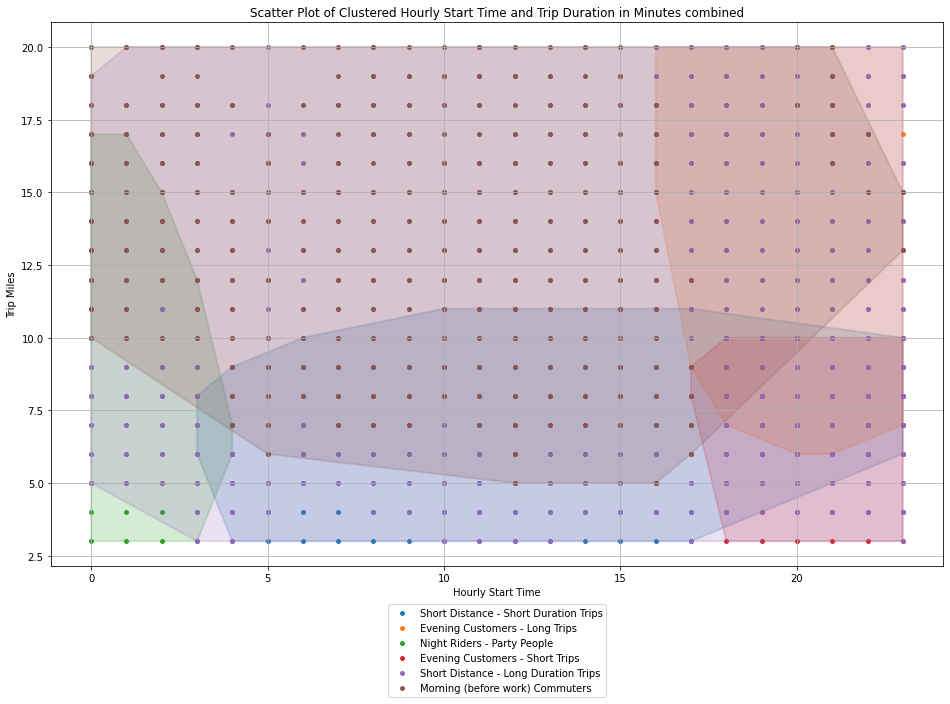

In [70]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_cluster.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Minutes', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in Minutes combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

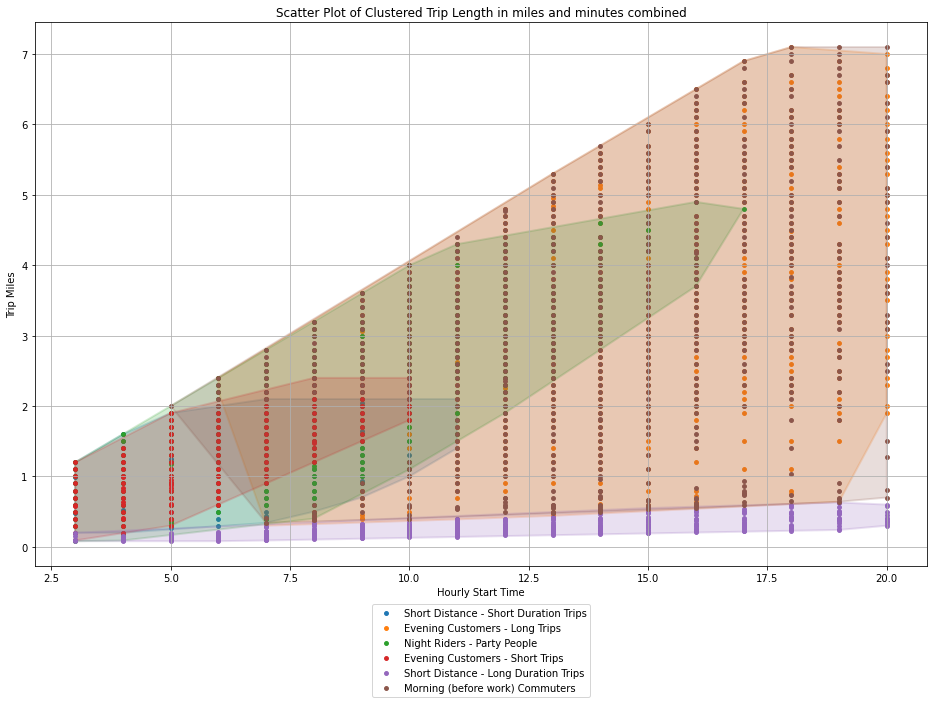

In [71]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_cluster.sample(n=10_000), x_col='Trip_Minutes', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Length in miles and minutes combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

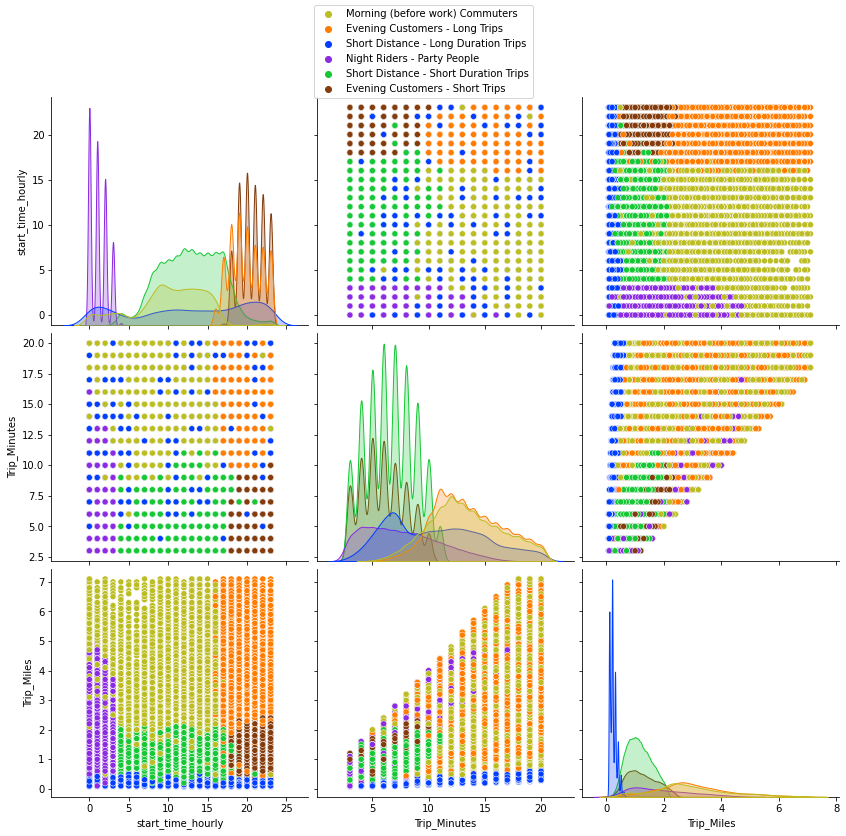

In [74]:
colors = {
          "Short Distance - Short Duration Trips" : '#16C835', 
            "Evening Customers - Long Trips":'#FF7C00',
            "Night Riders - Party People": '#8B2BE2',
             "Evening Customers - Short Trips": '#843C0C',
          "Short Distance - Long Duration Trips": '#023EFF',
           "Morning (before work) Commuters":'#bcbd22'}

g = sns.pairplot(data=df_chicago_cluster[['start_time_hourly', 'Trip_Minutes' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)

<hr style="border: 1px solid #8888;">

##  5. Fifth Cluster Analysis: `distance_to_city_center_pickup`

In [75]:
df_cluster_pickup = df_chicago[['distance_to_city_center_pickup']]

#### Scaling the data:

In [76]:
df_pickup_scaled = scaling_data(df_cluster_pickup)

### 2.1 Decision for number of clusters

In [16]:
df_score = df_pickup_scaled.sample(350000, random_state=42)
df_score

,distance_to_city_center_pickup
5361192,-0.552005
487735,2.254290
2121174,-0.377701
5764286,-0.558353
1384941,-0.924715
...,...
5056243,3.901850
8323004,1.000371
7294291,1.000371
7046141,-0.588211


### Silhouette score

In [17]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

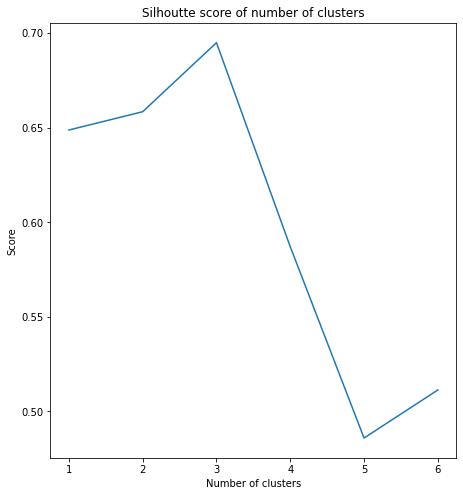

In [18]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_miles')
plt.show()

### Bayesian information criterion (BIC)

In [19]:
clusters_bic, scores_bic = bic(df_score, 6)

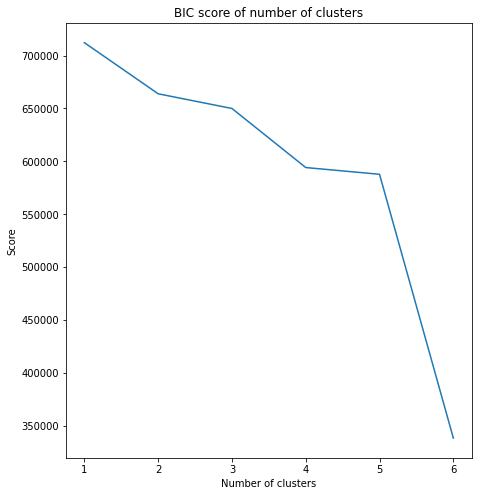

In [20]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_miles')
plt.show()

### 2.2 Use Gaussian Mixture Model and discover cluster

In [77]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_pickup_scaled)

In [78]:
cluster = gm.predict(df_pickup_scaled)

In [79]:
cluster_prob = gm.predict_proba(df_pickup_scaled)

In [80]:
df_cluster_pickup["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3887589208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup["cluster"] = cluster


In [81]:
for k in range(3):
    df_cluster_pickup[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3051875815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3051875815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3051875815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a

In [82]:
df_cluster_pickup

,distance_to_city_center_pickup,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob
0,1.614272,0,8.907030e-01,0.008286,0.101011
1,3.617721,2,5.739448e-06,0.057050,0.942944
2,2.685629,2,1.993433e-02,0.049946,0.930120
3,0.495382,0,9.878992e-01,0.002360,0.009741
4,4.526819,2,1.384896e-10,0.095231,0.904769
...,...,...,...,...,...
7247312,0.495382,0,9.878992e-01,0.002360,0.009741
7247313,4.435183,2,4.561298e-10,0.088931,0.911069
7247314,0.893287,0,9.830162e-01,0.002253,0.014731
7247315,0.725199,0,9.862015e-01,0.002143,0.011656


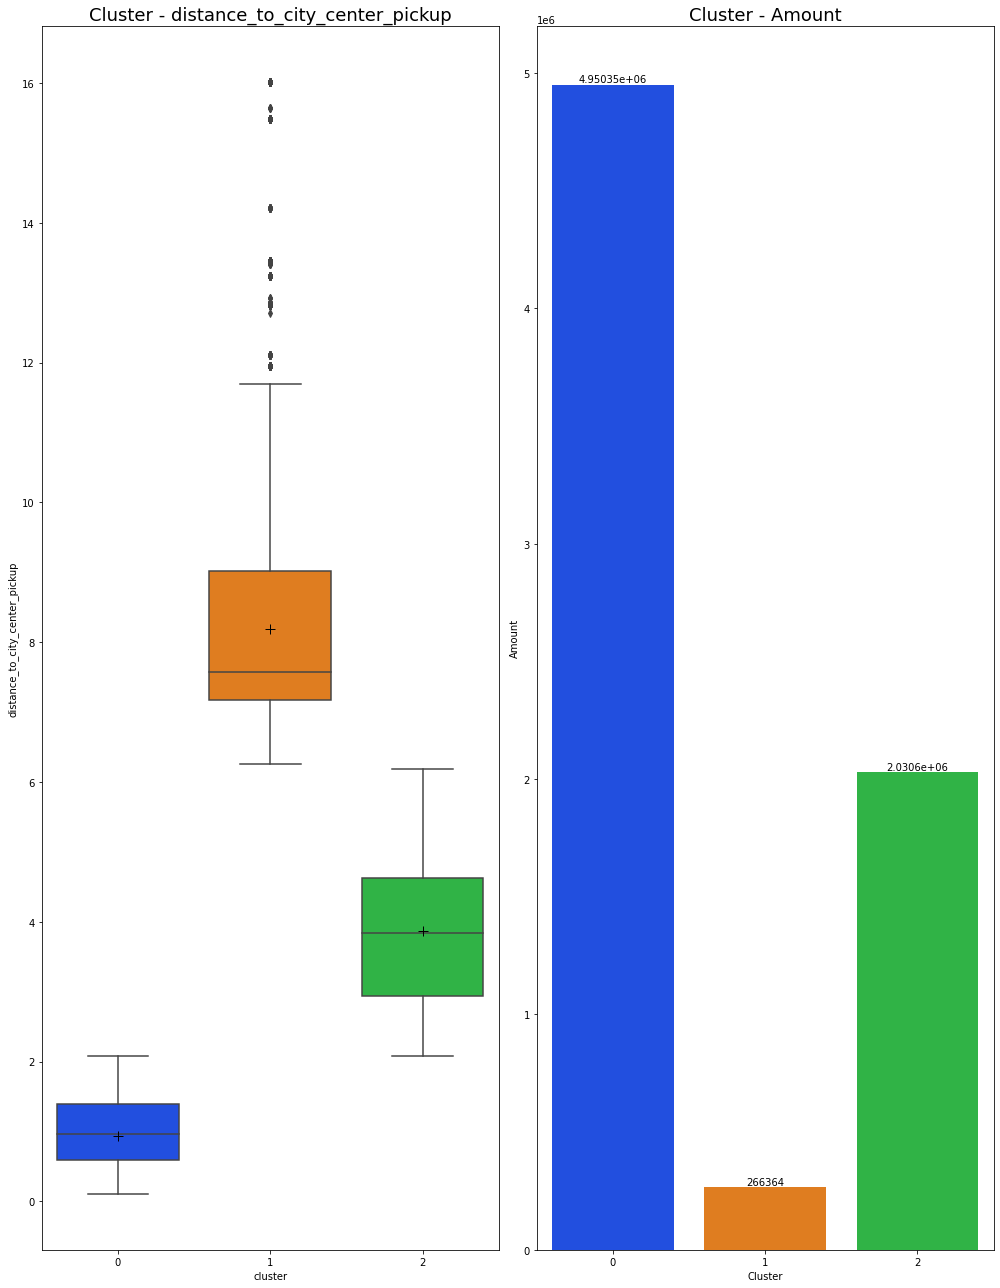

In [83]:
plot_information_about_clusters(df_cluster_pickup, ['distance_to_city_center_pickup'], 'cluster')

In [84]:
dfChicago_clu_miles_time_quantiles = get_quantiles_of_clusters(df_cluster_pickup, 3, 'cluster')
#dfChicago_clu_miles_time_quantiles.sort_values(by=['distance_to_city_center_pickup'], ascending=False)

In [85]:
dfChicago_clu_miles_time_quantiles

,distance_to_city_center_pickup,cluster_0_prob,cluster_1_prob,cluster_2_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,
0,0.59 - 1.39,0.95 - 0.99,0.0 - 0.0,0.01 - 0.05,4950351.0,68.31
1,7.18 - 9.01,0.0 - 0.0,0.86 - 1.0,0.0 - 0.14,266364.0,3.68
2,2.94 - 4.62,0.0 - 0.0,0.05 - 0.1,0.89 - 0.94,2030602.0,28.02


In [86]:
label_names = {'0': "Close to City Center", 
               '1': "Far from City Center",
               '2': "Medium Distance from the City Center"}

# integrating our labeled clusters in the dataframe
df_cluster_pickup['Cluster_Label'] = df_cluster_pickup['cluster'].astype(str)
df_cluster_pickup = df_cluster_pickup.replace({"Cluster_Label": label_names})

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3905506598.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup['Cluster_Label'] = df_cluster_pickup['cluster'].astype(str)


In [87]:
dfChicago_clu_pickup_index = df_cluster_pickup
dfChicago_clu_pickup_index['Trip_Index'] = df_cluster_pickup.index
dfChicago_clu_pickup_index

,distance_to_city_center_pickup,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,Cluster_Label,Trip_Index
0,1.614272,0,8.907030e-01,0.008286,0.101011,Close to City Center,0
1,3.617721,2,5.739448e-06,0.057050,0.942944,Medium Distance from the City Center,1
2,2.685629,2,1.993433e-02,0.049946,0.930120,Medium Distance from the City Center,2
3,0.495382,0,9.878992e-01,0.002360,0.009741,Close to City Center,3
4,4.526819,2,1.384896e-10,0.095231,0.904769,Medium Distance from the City Center,4
...,...,...,...,...,...,...,...
7247312,0.495382,0,9.878992e-01,0.002360,0.009741,Close to City Center,7247312
7247313,4.435183,2,4.561298e-10,0.088931,0.911069,Medium Distance from the City Center,7247313
7247314,0.893287,0,9.830162e-01,0.002253,0.014731,Close to City Center,7247314
7247315,0.725199,0,9.862015e-01,0.002143,0.011656,Close to City Center,7247315


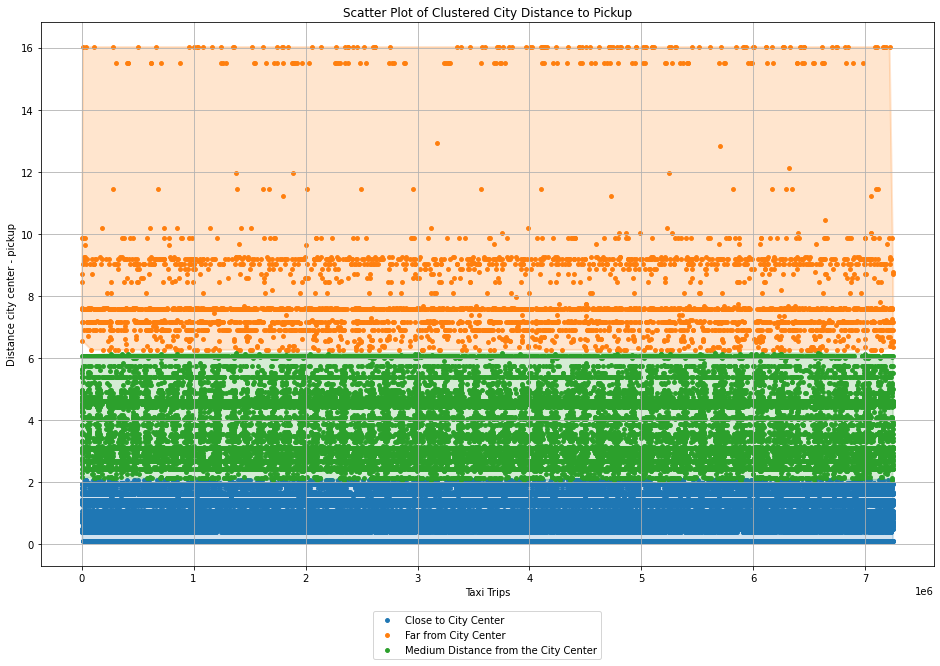

In [88]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_pickup_index.sample(n=100000), x_col='Trip_Index', y_col='distance_to_city_center_pickup', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Distance city center - pickup", plot_title='Scatter Plot of Clustered City Distance to Pickup', leg_loc='lower center', anchor=(0.5, -0.18))

### 5.5 Displaying Results on a Map of Chicago

In [89]:
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.DataFrame(dfChicago_clu_pickup_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_pickup_hex_ids, 
                                                                df_chicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_pickup_hex_ids

,distance_to_city_center_pickup,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,Cluster_Label,Trip_Index,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res
0,1.614272,0,8.907030e-01,0.008286,0.101011,Close to City Center,0,882664ca91fffff,872664ca9ffffff,862664cafffffff
1,3.617721,2,5.739448e-06,0.057050,0.942944,Medium Distance from the City Center,1,882664c12bfffff,872664c12ffffff,862664c17ffffff
2,2.685629,2,1.993433e-02,0.049946,0.930120,Medium Distance from the City Center,2,882664cac3fffff,872664cacffffff,862664cafffffff
3,0.495382,0,9.878992e-01,0.002360,0.009741,Close to City Center,3,882664c1adfffff,872664c1affffff,862664c1fffffff
4,4.526819,2,1.384896e-10,0.095231,0.904769,Medium Distance from the City Center,4,882664ca11fffff,872664ca1ffffff,862664ca7ffffff
...,...,...,...,...,...,...,...,...,...,...
7247312,0.495382,0,9.878992e-01,0.002360,0.009741,Close to City Center,7247312,882664c1adfffff,872664c1affffff,862664c1fffffff
7247313,4.435183,2,4.561298e-10,0.088931,0.911069,Medium Distance from the City Center,7247313,882664c10dfffff,872664c10ffffff,862664c17ffffff
7247314,0.893287,0,9.830162e-01,0.002253,0.014731,Close to City Center,7247314,882664c1e1fffff,872664c1effffff,862664c1fffffff
7247315,0.725199,0,9.862015e-01,0.002143,0.011656,Close to City Center,7247315,882664c1e3fffff,872664c1effffff,862664c1fffffff


In [96]:
# create lists of hex ids for each cluster
hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 0, 'h3_hex_id_high_res')
hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 1, 'h3_hex_id_high_res')
hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_2, color='#2ca02c') 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_1, color='#ff7f0e', folium_map=m_hex_high_pickup_distance_city_center) 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_0, color='#1f77b4', folium_map=m_hex_high_pickup_distance_city_center)
display(m_hex_high_pickup_distance_city_center)

<hr style="border: 1px solid #8888;">

##  6. Sixth Cluster Analysis: `distance_to_city_center_dropoff`

In [51]:
df_cluster_dropoff = df_chicago[['distance_to_city_center_dropoff']]

#### Scaling the data:

In [52]:
df_dropoff_scaled = scaling_data(df_cluster_dropoff)

### 2.1 Decision for number of clusters

In [53]:
df_score = df_dropoff_scaled.sample(350000, random_state=42)
df_score

,distance_to_city_center_dropoff
5361192,-0.671081
487735,1.490856
2121174,2.136684
5764286,-0.696972
1384941,-0.775683
...,...
5056243,0.844338
8323004,-0.370384
7294291,2.716103
7046141,-0.775683


### Silhouette score

In [54]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

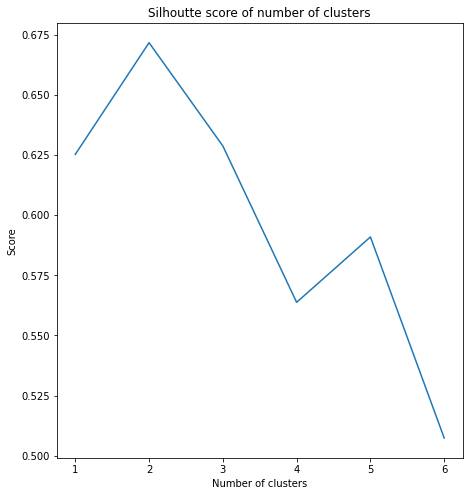

In [55]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_miles')
plt.show()

### Bayesian information criterion (BIC)

In [56]:
clusters_bic, scores_bic = bic(df_score, 6)

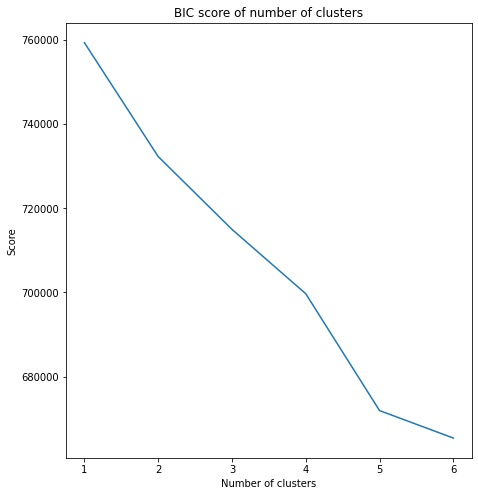

In [57]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_miles')
plt.show()

### 2.2 Use Gaussian Mixture Model and discover cluster

In [58]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_dropoff_scaled)

In [59]:
cluster = gm.predict(df_dropoff_scaled)

In [60]:
cluster_prob = gm.predict_proba(df_dropoff_scaled)

In [61]:
df_cluster_dropoff["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/1189943988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff["cluster"] = cluster


In [62]:
for k in range(3):
    df_cluster_dropoff[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/2649727858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/2649727858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/2649727858.py:2: SettingWithCopyWarning: 
A value is trying to be set

In [63]:
df_cluster_dropoff

,distance_to_city_center_dropoff,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob
0,1.387700,1,0.059118,9.328036e-01,0.008078
1,3.548918,0,0.912507,3.725264e-05,0.087456
2,6.577887,2,0.314738,2.290593e-23,0.685262
3,2.685629,0,0.892248,3.162975e-02,0.076122
4,0.587129,1,0.016559,9.789856e-01,0.004455
...,...,...,...,...,...
8974515,1.959038,1,0.325788,6.413301e-01,0.032882
8974516,4.414539,0,0.868043,4.556473e-09,0.131957
8974517,1.609951,1,0.111374,8.753386e-01,0.013287
8974518,2.141079,0,0.519318,4.315623e-01,0.049120


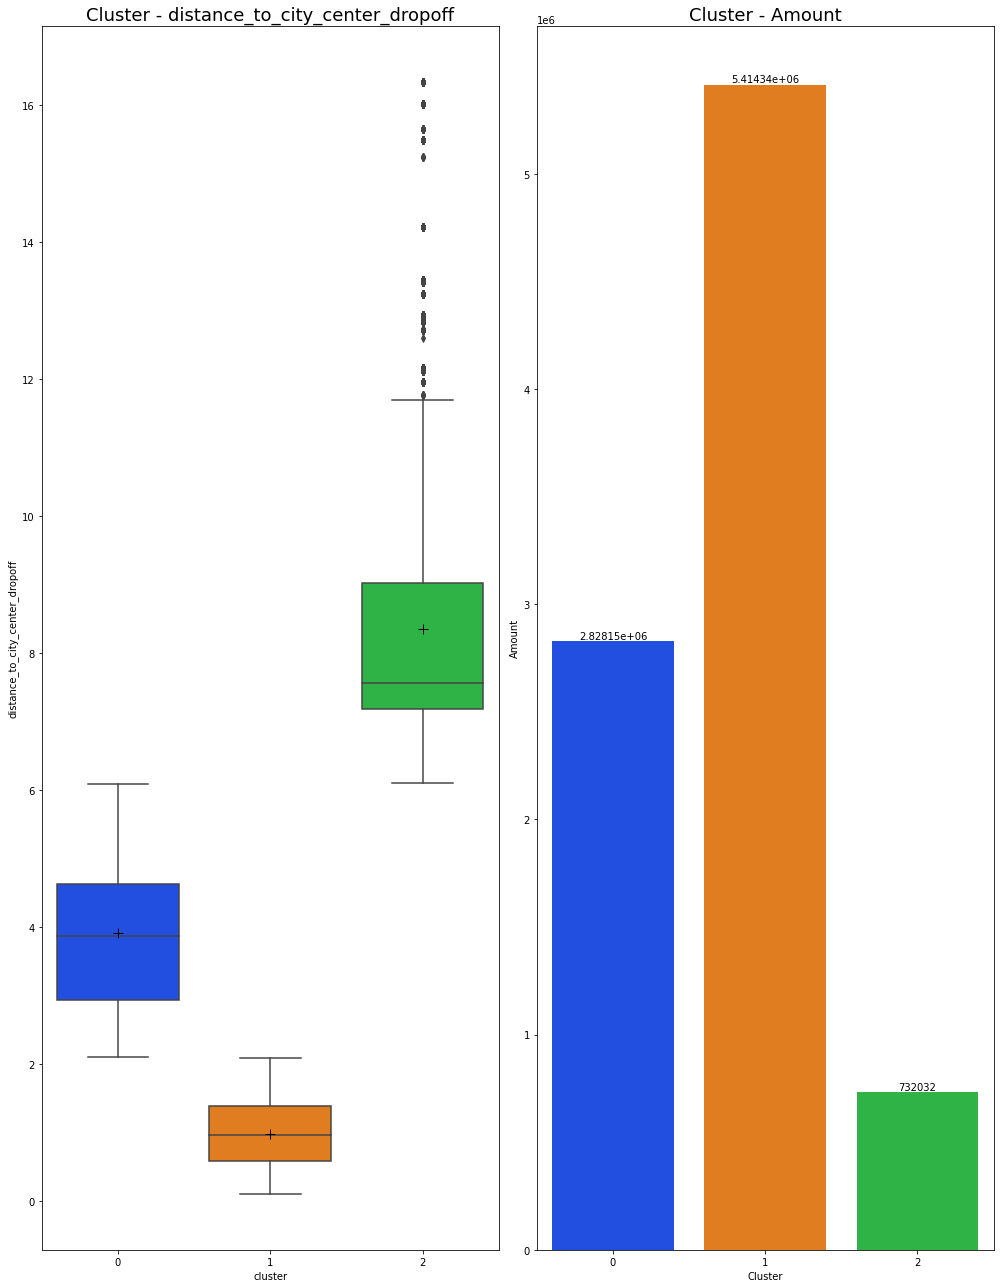

In [64]:
plot_information_about_clusters(df_cluster_dropoff, ['distance_to_city_center_dropoff'], 'cluster')

In [65]:
dfChicago_clu_miles_time_quantiles = get_quantiles_of_clusters(df_cluster_dropoff, 3, 'cluster')
dfChicago_clu_miles_time_quantiles
#dfChicago_clu_miles_time_quantiles.sort_values(by=['distance_to_city_center_pickup'], ascending=False)

,distance_to_city_center_dropoff,cluster_0_prob,cluster_1_prob,cluster_2_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,
0,2.94 - 4.62,0.82 - 0.91,0.0 - 0.01,0.08 - 0.15,2828147.0,31.51
1,0.59 - 1.39,0.02 - 0.06,0.93 - 0.97,0.0 - 0.01,5414341.0,60.33
2,7.18 - 9.01,0.0 - 0.13,0.0 - 0.0,0.87 - 1.0,732032.0,8.16


In [66]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
df_cluster_dropoff['Cluster_Label'] = df_cluster_dropoff['cluster'].astype(str)
df_cluster_dropoff = df_cluster_dropoff.replace({"Cluster_Label": label_names})

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/3975095452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff['Cluster_Label'] = df_cluster_dropoff['cluster'].astype(str)


In [67]:
dfChicago_clu_dropoff_index = df_cluster_dropoff
dfChicago_clu_dropoff_index['Trip_Index'] = df_cluster_dropoff.index
dfChicago_clu_dropoff_index

,distance_to_city_center_dropoff,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,Cluster_Label,Trip_Index
0,1.387700,1,0.059118,9.328036e-01,0.008078,Night Riders - Party People,0
1,3.548918,0,0.912507,3.725264e-05,0.087456,Evening Commuters,1
2,6.577887,2,0.314738,2.290593e-23,0.685262,Morning Commuters,2
3,2.685629,0,0.892248,3.162975e-02,0.076122,Evening Commuters,3
4,0.587129,1,0.016559,9.789856e-01,0.004455,Night Riders - Party People,4
...,...,...,...,...,...,...,...
8974515,1.959038,1,0.325788,6.413301e-01,0.032882,Night Riders - Party People,8974515
8974516,4.414539,0,0.868043,4.556473e-09,0.131957,Evening Commuters,8974516
8974517,1.609951,1,0.111374,8.753386e-01,0.013287,Night Riders - Party People,8974517
8974518,2.141079,0,0.519318,4.315623e-01,0.049120,Evening Commuters,8974518


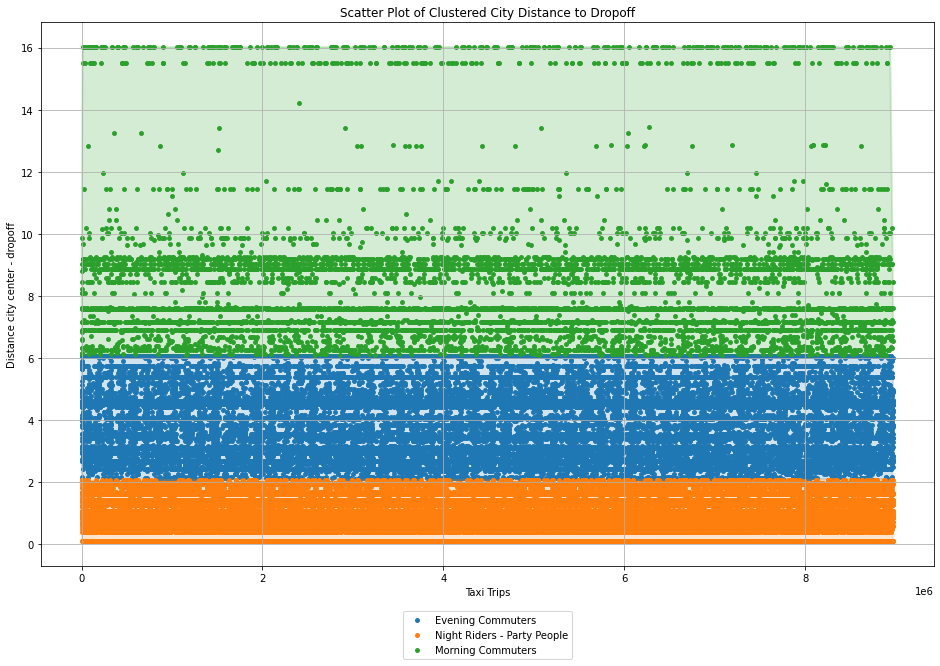

In [68]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_dropoff_index.sample(n=100000), x_col='Trip_Index', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Distance city center - dropoff", plot_title='Scatter Plot of Clustered City Distance to Dropoff', leg_loc='lower center', anchor=(0.5, -0.18))

<hr style="border: 1px solid #8888;">

##  7. Seventh Cluster Analysis: `distance_to_city_center_dropoff`, `distance_to_city_center_pickup`, `Trip_Minutes` and `Trip_Miles`

In [171]:
df_chicago_location = df_chicago[['distance_to_city_center_pickup','distance_to_city_center_dropoff',"Trip_Miles",'Trip_Minutes']]

#### Scaling the data:

In [172]:
df_location_scaled = scaling_data(df_chicago_location)

In [173]:
df_location_scaled

,distance_to_city_center_pickup,distance_to_city_center_dropoff,Trip_Miles,Trip_Minutes
0,-0.211553,-0.389883,0.787302,1.343110
1,0.815253,0.660510,-0.970516,-1.242093
2,0.337538,0.240935,-0.511955,-1.477111
3,-0.785005,-0.778976,-1.046943,-1.242093
4,1.281183,1.135788,-0.664808,-0.302019
...,...,...,...,...
7247312,-0.785005,-0.823566,-0.894089,-1.477111
7247313,1.234218,2.380606,2.621546,2.283184
7247314,-0.581071,-0.112202,-0.206247,-0.067001
7247315,-0.667220,-0.281865,0.252314,0.638055


### 6.1 Decision for number of clusters

In [122]:
df_score = df_location_scaled.sample(750000, random_state=42)
df_score

,distance_to_city_center_pickup,distance_to_city_center_dropoff,Trip_Miles
6337986,0.531277,1.240208,-1.123370
1276690,-0.785005,1.507590,-1.046943
1248107,-0.581071,-1.014293,-0.511955
6948608,0.663752,0.317574,-1.215082
1253462,-0.320689,-0.383258,-0.817662
...,...,...,...
4111997,-0.709613,-0.098104,-0.129820
1387658,-0.368851,-0.752072,-0.741235
6276294,-0.594371,-0.588849,-0.664808
3769332,-0.327675,1.183171,-1.123370


### Silhouette score

In [123]:
clusters_sil, scores_sil = silhoutte(df_score, 10)

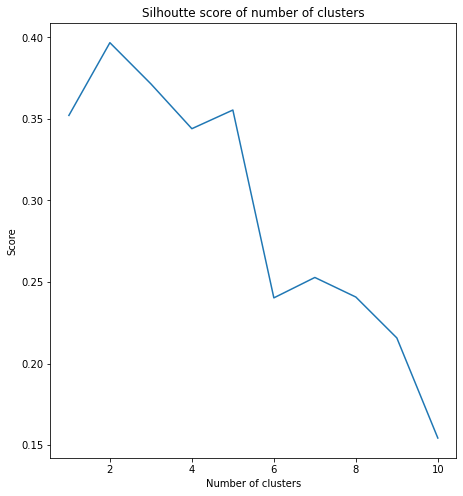

In [124]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score')
plt.show()

### Bayesian information criterion (BIC)

In [125]:
clusters_bic, scores_bic = bic(df_score, 10)

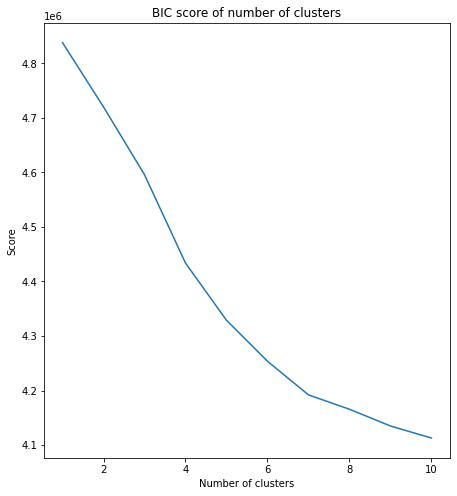

In [126]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score')
plt.show()

### 1.2 Use Gaussian Mixture Model and discover cluster

In [127]:
gm = GaussianMixture(n_components=5, random_state=42, n_init = 15).fit(df_location__scaled)

In [128]:
cluster = gm.predict(df_location_scaled)

In [129]:
cluster_prob = gm.predict_proba(df_location_scaled)

In [130]:
df_chicago_location["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/2961882598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miles_location["cluster"] = cluster


In [131]:
for k in range(5):
    df_chicago_location[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/1111398160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miles_location[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/1111398160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miles_location[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_42908/1111398160.py:2: SettingWithCopyWarning: 
A value is trying to be set o

In [132]:
df_chicago_location

,distance_to_city_center_pickup,distance_to_city_center_dropoff,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob
0,1.614272,1.387700,2.7,4,7.406625e-03,6.068963e-02,4.401375e-47,0.015231,9.166723e-01
1,3.617721,3.548918,0.4,2,2.787897e-13,2.156717e-01,7.321167e-01,0.052212,5.388524e-12
2,2.685629,2.685629,1.0,1,5.790503e-05,8.657693e-01,2.996220e-04,0.133708,1.652003e-04
3,0.495382,0.587129,0.3,0,9.570741e-01,4.398742e-03,2.416325e-02,0.000728,1.363633e-02
4,4.526819,4.526819,0.8,1,4.407107e-23,5.923711e-01,7.775655e-02,0.329872,1.661802e-18
...,...,...,...,...,...,...,...,...,...
7247312,0.495382,0.495382,0.5,0,9.770291e-01,3.587407e-03,3.628090e-03,0.000605,1.515091e-02
7247313,4.435183,7.088074,5.1,3,1.974237e-56,4.402880e-12,8.064068e-163,1.000000,5.750118e-18
7247314,0.893287,1.959038,1.4,0,5.984727e-01,1.768912e-02,1.191377e-11,0.015984,3.678542e-01
7247315,0.725199,1.609951,2.0,4,2.979474e-01,7.165446e-03,2.116857e-25,0.014592,6.802951e-01


### 1.3 Analyze and plot the cluster

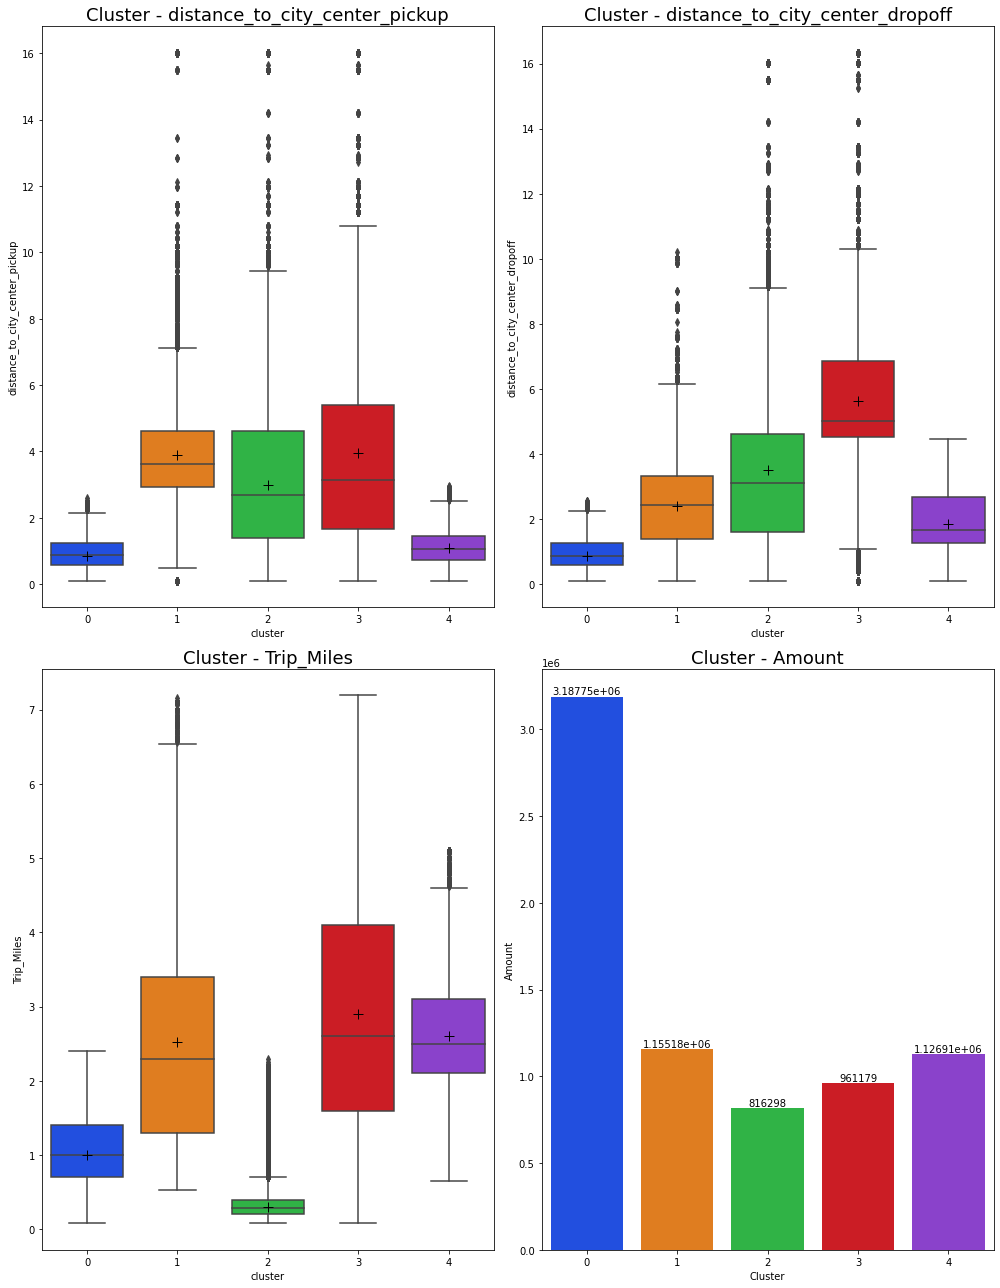

In [133]:
plot_information_about_clusters(df_chicago_location,
     ['distance_to_city_center_pickup','distance_to_city_center_dropoff',"Trip_Miles","Trip_Minutes"], 'cluster')

In [134]:
dfChicago_clu_location_quantiles = get_quantiles_of_clusters(df_miles_location, 4, 'cluster')
dfChicago_clu_location_quantiles

,distance_to_city_center_pickup,distance_to_city_center_dropoff,Trip_Miles,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,Amount Trips in Cluster,Percentage
Cluster,,,,,,,,,,
0,0.59 - 1.23,0.59 - 1.27,0.7 - 1.4,0.84 - 0.96,0.0 - 0.01,0.0 - 0.0,0.0 - 0.0,0.02 - 0.1,3187748.0,43.99
1,2.94 - 4.62,1.39 - 3.32,1.3 - 3.4,0.0 - 0.0,0.73 - 0.99,0.0 - 0.0,0.0 - 0.17,0.0 - 0.01,1155180.0,15.94
2,1.39 - 4.62,1.61 - 4.62,0.2 - 0.4,0.0 - 0.0,0.0 - 0.09,0.78 - 1.0,0.0 - 0.03,0.0 - 0.0,816298.0,11.26
3,1.68 - 5.39,4.53 - 6.85,1.6 - 4.1,0.0 - 0.0,0.0 - 0.07,0.0 - 0.0,0.82 - 1.0,0.0 - 0.01,961179.0,13.26


In [164]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Morning Commuters",
              '3': "xbh",
               '4': "ybh"}

# integrating our labeled clusters in the dataframe
df_miles_location['Cluster_Label'] = df_miles_location['cluster'].astype(str)
df_miles_location = df_miles_location.replace({"Cluster_Label": label_names})

In [165]:
dfChicago_clu_dropoff_index = df_miles_location
dfChicago_clu_dropoff_index['Trip_Index'] = df_miles_location.index
dfChicago_clu_dropoff_index

,distance_to_city_center_pickup,distance_to_city_center_dropoff,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,Cluster_Label,Trip_Index
0,1.614272,1.387700,2.7,4,7.406625e-03,6.068963e-02,4.401375e-47,0.015231,9.166723e-01,ybh,0
1,3.617721,3.548918,0.4,2,2.787897e-13,2.156717e-01,7.321167e-01,0.052212,5.388524e-12,Morning Commuters,1
2,2.685629,2.685629,1.0,1,5.790503e-05,8.657693e-01,2.996220e-04,0.133708,1.652003e-04,Night Riders - Party People,2
3,0.495382,0.587129,0.3,0,9.570741e-01,4.398742e-03,2.416325e-02,0.000728,1.363633e-02,Evening Commuters,3
4,4.526819,4.526819,0.8,1,4.407107e-23,5.923711e-01,7.775655e-02,0.329872,1.661802e-18,Night Riders - Party People,4
...,...,...,...,...,...,...,...,...,...,...,...
7247312,0.495382,0.495382,0.5,0,9.770291e-01,3.587407e-03,3.628090e-03,0.000605,1.515091e-02,Evening Commuters,7247312
7247313,4.435183,7.088074,5.1,3,1.974237e-56,4.402880e-12,8.064068e-163,1.000000,5.750118e-18,xbh,7247313
7247314,0.893287,1.959038,1.4,0,5.984727e-01,1.768912e-02,1.191377e-11,0.015984,3.678542e-01,Evening Commuters,7247314
7247315,0.725199,1.609951,2.0,4,2.979474e-01,7.165446e-03,2.116857e-25,0.014592,6.802951e-01,ybh,7247315


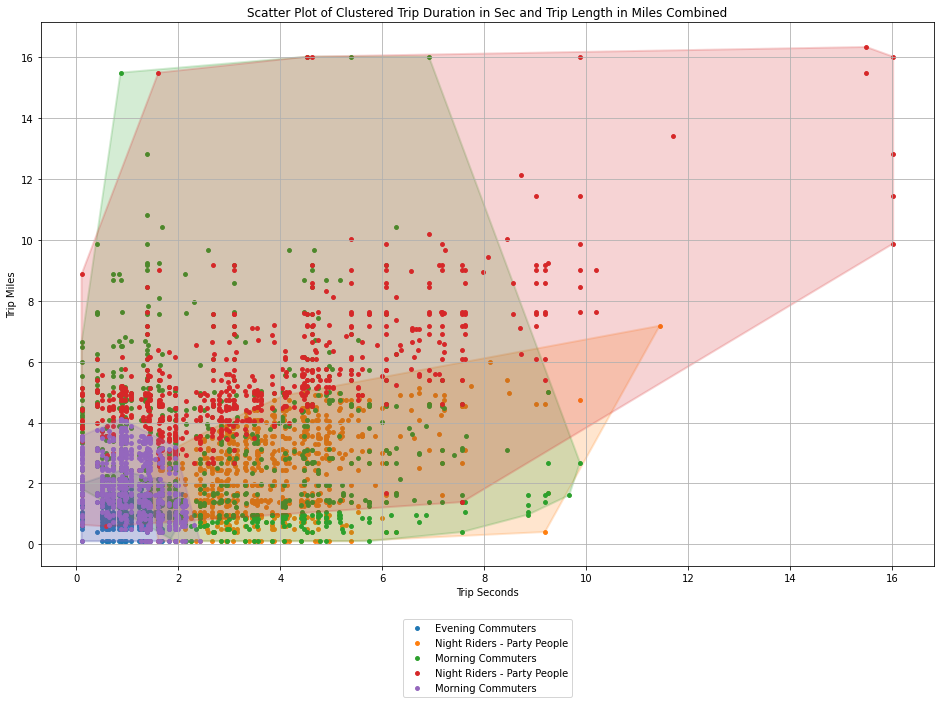

In [160]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_miles_location.sample(n=10_000), x_col='distance_to_city_center_pickup', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Seconds', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Duration in Sec and Trip Length in Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

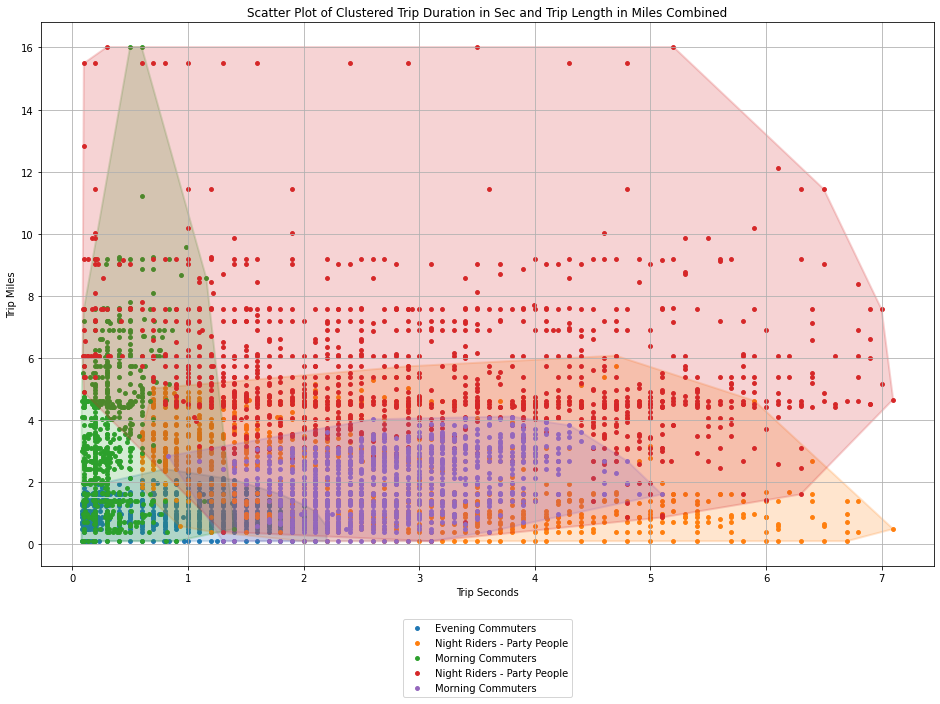

In [157]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_miles_location.sample(n=10_000), x_col='Trip_Miles', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Seconds', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Duration in Sec and Trip Length in Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

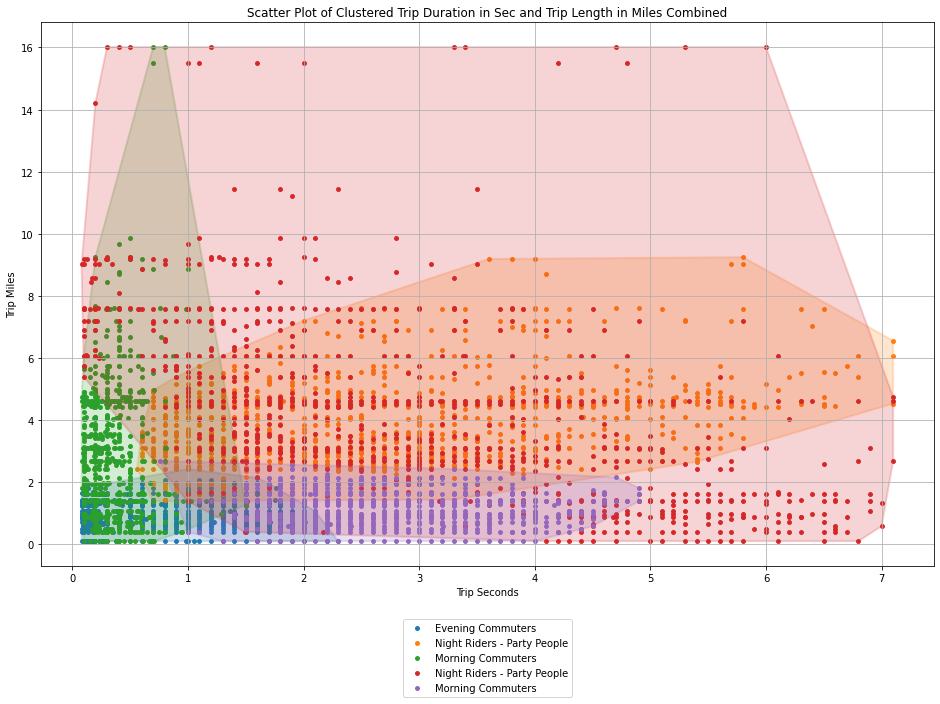

In [158]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_miles_location.sample(n=10_000), x_col='Trip_Miles', y_col='distance_to_city_center_pickup', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Seconds', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Duration in Sec and Trip Length in Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

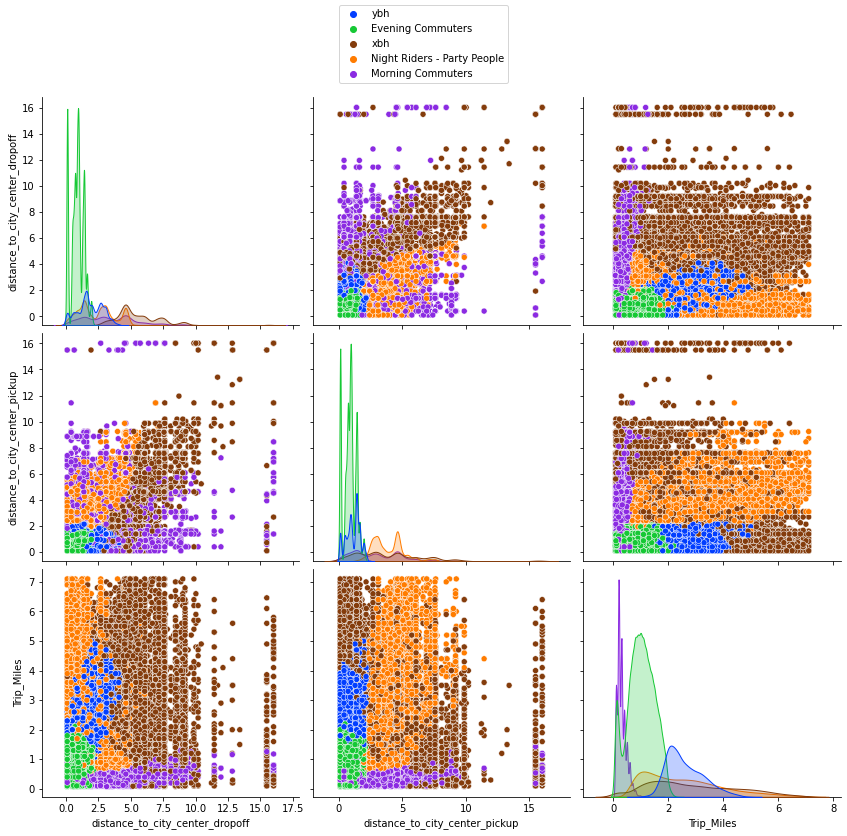

In [170]:
colors = {'Evening Commuters' : '#16C835',
          'Night Riders - Party People' : '#FF7C00',
          'Morning Commuters' : '#8B2BE2',
          'xbh' : '#843C0C',
          'ybh': '#023EFF'}

g = sns.pairplot(data=df_miles_location[['distance_to_city_center_dropoff', 
                                'distance_to_city_center_pickup' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)